In [2]:
# Import required libraries

# pandas - For data manipulation and analysis of tabular data (landmarks and protocol files)
import pandas as pd

# numpy - For numerical operations and array manipulation of pupil measurements
import numpy as np

# matplotlib - For creating static visualizations of pupil response data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
plt.style.use('dark_background')

# pathlib - For cross-platform file path handling
from pathlib import Path

# logging - For tracking program execution and debugging information
import logging

# scipy.signal - For signal processing operations like Savitzky-Golay filtering
from scipy import signal

# seaborn - For enhanced statistical data visualization built on matplotlib
import seaborn as sns

# shapely.geometry - For polygon area calculation
from shapely.geometry import Polygon

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [3]:
batches_path = Path().cwd().parent / "data"

landmarks_path = r"/home/lrn/Repos/analyze-eye-tracking-data/data/5e0e4c36-8b30-41fd-a1b8-cae6a7ffd9e4/5e0e4c36-8b30-41fd-a1b8-cae6a7ffd9e4_plr_landmarks.csv"
protocol_path = r"/home/lrn/Repos/analyze-eye-tracking-data/data/5e0e4c36-8b30-41fd-a1b8-cae6a7ffd9e4/5e0e4c36-8b30-41fd-a1b8-cae6a7ffd9e4_plr_protocol.csv"

In [4]:
landmarks_df = pd.read_csv(landmarks_path)
landmarks_df

Unnamed: 0                timestamp    id retcode  left_lm_1_x  \
0             0  2024-08-29 13:09:22.559  1852      OK        196.3   
1             1  2024-08-29 13:09:22.592  1853      OK        197.0   
2             2  2024-08-29 13:09:22.621  1854      OK        198.5   
3             3  2024-08-29 13:09:22.652  1855      OK        199.8   
4             4  2024-08-29 13:09:22.682  1856      OK        200.3   
..          ...                      ...   ...     ...          ...   
263         263  2024-08-29 13:09:31.414  2115      OK        217.5   
264         264  2024-08-29 13:09:31.454  2116      OK        217.8   
265         265  2024-08-29 13:09:31.484  2117      OK        216.3   
266         266  2024-08-29 13:09:31.516  2118      OK        210.5   
267         267  2024-08-29 13:09:31.556  2119      OK        205.5   

     left_lm_1_y  left_lm_2_x  left_lm_2_y  left_lm_3_x  left_lm_3_y  ...  \
0          977.8        255.3        936.5        294.0        934.3  ...   
1          977.0        255.3        935.0        294.3        932.5  ...   
2          976.3        257.0        934.0        295.5        931.5  ...   
3          974.5        257.5        932.3        296.0        929.8  ...   
4          971.8        259.0        930.8        296.8        929.3  ...   
..           ...          ...          ...          ...          ...  ...   
263        973.8        271.8        930.3        311.0        926.0  ...   
264        971.5        272.8        930.3        310.5        926.3  ...   
265        969.3        271.0        927.5        308.3        923.8  ...   
266        968.5        265.5        926.0        303.5        922.3  ...   
267        967.3        259.8        924.0        297.0        920.5  ...   

     right_lm_23_x  right_lm_23_y  right_lm_24_x  right_lm_24_y  \
0            795.8          960.8          753.0          961.0   
1            796.0          959.0          754.8          959.3   
2            797.0          957.5          755.0          957.8   
3            797.8          956.3          755.3          956.5   
4            798.0          955.3          756.0          955.5   
..             ...            ...            ...            ...   
263          802.0          955.8          771.3          955.8   
264          800.5          954.5          769.0          954.5   
265          797.3          951.3          766.3          951.5   
266          792.3          949.5          761.0          949.5   
267          786.3          948.3          755.3          948.5   

     right_lm_25_x  right_lm_25_y  right_lm_26_x  right_lm_26_y  \
0            754.0          985.5          850.8          959.5   
1            755.8          983.3          853.0          959.3   
2            755.8          982.3          852.5          957.8   
3            756.0          981.3          853.8          956.3   
4            756.5          980.3          853.8          956.3   
..             ...            ...            ...            ...   
263          772.3          973.3          861.3          951.5   
264          769.8          971.0          860.5          949.5   
265          767.5          968.8          857.5          947.8   
266          762.0          966.8          851.0          944.5   
267          756.3          965.3          846.0          943.3   

     right_lm_27_x  right_lm_27_y  
0            892.3          987.3  
1            896.5          987.3  
2            895.3          986.3  
3            895.0          984.5  
4            896.3          984.0  
..             ...            ...  
263          900.5          981.0  
264          898.0          978.3  
265          896.3          976.3  
266          890.8          975.3  
267          886.0          973.5  

[268 rows x 112 columns]

In [5]:
landmarks_df['timestamp'] = pd.to_datetime(landmarks_df['timestamp'])
float_columns = landmarks_df.select_dtypes(include=['float64']).columns
landmarks_df[float_columns] = landmarks_df[float_columns].astype('float32')

In [6]:
print(landmarks_df.dtypes)

Unnamed: 0                int64
timestamp        datetime64[ns]
id                        int64
retcode                  object
left_lm_1_x             float32
                      ...      
right_lm_25_y           float32
right_lm_26_x           float32
right_lm_26_y           float32
right_lm_27_x           float32
right_lm_27_y           float32
Length: 112, dtype: object


In [7]:
ok_landmarks_df = landmarks_df[landmarks_df['retcode'] == 'OK'].copy()
   
    # Reset index after filtering
ok_landmarks_df.reset_index(drop=True, inplace=True)

logger.info(f"Removed {len(landmarks_df) - len(ok_landmarks_df)} frames with invalid retCode")

2025-04-20 06:10:18,055 - INFO - Removed 0 frames with invalid retCode


In [8]:
index = 2
ok_landmarks_df.iloc[index]['left_lm_8_x']

np.float32(295.3)

In [9]:
# Create the results DataFrame by selecting 'id' and 'timestamp' columns from ok_landmarks_df
results = ok_landmarks_df[['id', 'timestamp']].copy()

# Display the new results DataFrame
results


id               timestamp
0    1852 2024-08-29 13:09:22.559
1    1853 2024-08-29 13:09:22.592
2    1854 2024-08-29 13:09:22.621
3    1855 2024-08-29 13:09:22.652
4    1856 2024-08-29 13:09:22.682
..    ...                     ...
263  2115 2024-08-29 13:09:31.414
264  2116 2024-08-29 13:09:31.454
265  2117 2024-08-29 13:09:31.484
266  2118 2024-08-29 13:09:31.516
267  2119 2024-08-29 13:09:31.556

[268 rows x 2 columns]

In [10]:
# Print the data types of each column in the results DataFrame
print(results.dtypes)

id                    int64
timestamp    datetime64[ns]
dtype: object


In [11]:
def extract_center(row: pd.Series, side: str) -> tuple:
    """ Extract the center tuple of points (x,y) of the eye (left or right). """
    return (row[f'{side}_lm_8_x'], row[f'{side}_lm_8_y'])

for side in ['left', 'right']:
    # Apply the function to each row of the DataFrame and create new columns
    results[f'center_{side}'] = ok_landmarks_df.apply(extract_center, axis=1, side=side)

results

id               timestamp                              center_left  \
0    1852 2024-08-29 13:09:22.559              (292.79998779296875, 967.0)   
1    1853 2024-08-29 13:09:22.592                           (294.0, 965.0)   
2    1854 2024-08-29 13:09:22.621  (295.29998779296875, 965.2999877929688)   
3    1855 2024-08-29 13:09:22.652               (296.0, 962.7999877929688)   
4    1856 2024-08-29 13:09:22.682              (295.79998779296875, 961.0)   
..    ...                     ...                                      ...   
263  2115 2024-08-29 13:09:31.414              (311.79998779296875, 962.0)   
264  2116 2024-08-29 13:09:31.454                           (310.5, 961.0)   
265  2117 2024-08-29 13:09:31.484  (307.79998779296875, 958.7999877929688)   
266  2118 2024-08-29 13:09:31.516               (303.0, 958.2999877929688)   
267  2119 2024-08-29 13:09:31.556                           (297.5, 957.0)   

                               center_right  
0    (774.2999877929688, 973.2999877929688)  
1                (775.2999877929688, 971.0)  
2                            (776.0, 970.0)  
3    (776.2999877929688, 968.7999877929688)  
4                (776.5, 967.7999877929688)  
..                                      ...  
263  (786.7999877929688, 964.2999877929688)  
264  (784.7999877929688, 962.2999877929688)  
265              (781.7999877929688, 960.0)  
266                          (776.5, 958.0)  
267              (770.7999877929688, 956.5)  

[268 rows x 4 columns]

In [12]:
def extract_sclera_points(row: pd.Series, side: str) -> list[tuple]:
    """ Extract a list of coordinates tuples of all points that form the sclera fissure, using the landmarks: [1, 21, 12, 19, 14, 15, 5, 17, 4, 3, 2, 26]"""
    return [
        (row[f'{side}_lm_1_x'], row[f'{side}_lm_1_y']),
        (row[f'{side}_lm_21_x'], row[f'{side}_lm_21_y']),
        (row[f'{side}_lm_12_x'], row[f'{side}_lm_12_y']),
        (row[f'{side}_lm_19_x'], row[f'{side}_lm_19_y']),
        (row[f'{side}_lm_14_x'], row[f'{side}_lm_14_y']),
        (row[f'{side}_lm_15_x'], row[f'{side}_lm_15_y']),
        (row[f'{side}_lm_5_x'], row[f'{side}_lm_5_y']),
        (row[f'{side}_lm_17_x'], row[f'{side}_lm_17_y']),
        (row[f'{side}_lm_4_x'], row[f'{side}_lm_4_y']),
        (row[f'{side}_lm_3_x'], row[f'{side}_lm_3_y']),
        (row[f'{side}_lm_2_x'], row[f'{side}_lm_2_y']),
        (row[f'{side}_lm_26_x'], row[f'{side}_lm_26_y'])
    ]


def extract_iris_points(row: pd.Series, side: str) -> list[tuple]:
    """ Extract a list of coordinates tuples of all points that form the side ball, using the landmarks: [11, 20, 13, 18, 6] """
    return [
        (row[f'{side}_lm_11_x'], row[f'{side}_lm_11_y']),
        (row[f'{side}_lm_20_x'], row[f'{side}_lm_20_y']),
        (row[f'{side}_lm_13_x'], row[f'{side}_lm_13_y']),
        (row[f'{side}_lm_18_x'], row[f'{side}_lm_18_y']),
        (row[f'{side}_lm_6_x'], row[f'{side}_lm_6_y'])
    ]

def extract_pupil_points(row: pd.Series, side: str) -> list[tuple]:
    """ Extract a list of coordinates tuples of all points that form the pupil, using the landmarks: [7, 25, 9, 22, 10, 23, 24] """
    return [
        (row[f'{side}_lm_7_x'], row[f'{side}_lm_7_y']),
        (row[f'{side}_lm_25_x'], row[f'{side}_lm_25_y']),
        (row[f'{side}_lm_9_x'], row[f'{side}_lm_9_y']),
        (row[f'{side}_lm_22_x'], row[f'{side}_lm_22_y']),
        (row[f'{side}_lm_10_x'], row[f'{side}_lm_10_y']),
        (row[f'{side}_lm_23_x'], row[f'{side}_lm_23_y']),
        (row[f'{side}_lm_24_x'], row[f'{side}_lm_24_y'])
    ]

for side in ['left', 'right']:
    # Apply the function to each row of the DataFrame and create new columns
    results[f'points_pupil_{side}'] = ok_landmarks_df.apply(extract_pupil_points, axis=1, side=side)
    results[f'points_iris_{side}'] = ok_landmarks_df.apply(extract_iris_points, axis=1, side=side)
    results[f'points_sclera_{side}'] = ok_landmarks_df.apply(extract_sclera_points, axis=1, side=side)

results

id               timestamp                              center_left  \
0    1852 2024-08-29 13:09:22.559              (292.79998779296875, 967.0)   
1    1853 2024-08-29 13:09:22.592                           (294.0, 965.0)   
2    1854 2024-08-29 13:09:22.621  (295.29998779296875, 965.2999877929688)   
3    1855 2024-08-29 13:09:22.652               (296.0, 962.7999877929688)   
4    1856 2024-08-29 13:09:22.682              (295.79998779296875, 961.0)   
..    ...                     ...                                      ...   
263  2115 2024-08-29 13:09:31.414              (311.79998779296875, 962.0)   
264  2116 2024-08-29 13:09:31.454                           (310.5, 961.0)   
265  2117 2024-08-29 13:09:31.484  (307.79998779296875, 958.7999877929688)   
266  2118 2024-08-29 13:09:31.516               (303.0, 958.2999877929688)   
267  2119 2024-08-29 13:09:31.556                           (297.5, 957.0)   

                               center_right  \
0    (774.2999877929688, 973.2999877929688)   
1                (775.2999877929688, 971.0)   
2                            (776.0, 970.0)   
3    (776.2999877929688, 968.7999877929688)   
4                (776.5, 967.7999877929688)   
..                                      ...   
263  (786.7999877929688, 964.2999877929688)   
264  (784.7999877929688, 962.2999877929688)   
265              (781.7999877929688, 960.0)   
266                          (776.5, 958.0)   
267              (770.7999877929688, 956.5)   

                                     points_pupil_left  \
0    [(317.0, 966.7999877929688), (313.299987792968...   
1    [(317.79998779296875, 965.0), (313.79998779296...   
2    [(318.0, 965.2999877929688), (314.299987792968...   
3    [(318.29998779296875, 962.7999877929688), (314...   
4    [(319.5, 961.0), (315.5, 973.5), (295.79998779...   
..                                                 ...   
263  [(328.0, 962.2999877929688), (325.5, 970.29998...   
264  [(326.5, 961.2999877929688), (324.0, 969.0), (...   
265  [(324.5, 958.7999877929688), (321.799987792968...   
266  [(319.5, 958.2999877929688), (317.0, 966.29998...   
267  [(313.79998779296875, 957.0), (311.29998779296...   

                                      points_iris_left  \
0    [(241.0, 967.0), (248.3000030517578, 991.29998...   
1    [(242.5, 965.0), (249.0, 989.2999877929688), (...   
2    [(243.3000030517578, 965.5), (250.0, 988.79998...   
3    [(243.8000030517578, 962.7999877929688), (250....   
4    [(244.0, 961.2999877929688), (251.0, 986.0), (...   
..                                                 ...   
263  [(261.5, 962.0), (267.5, 985.0), (311.5, 1006....   
264  [(260.0, 961.0), (266.0, 983.5), (310.5, 1004....   
265  [(257.5, 958.7999877929688), (263.799987792968...   
266  [(252.8000030517578, 958.2999877929688), (258....   
267  [(247.0, 957.0), (253.3000030517578, 979.5), (...   

                                    points_sclera_left  \
0    [(196.3000030517578, 977.7999877929688), (219....   
1    [(197.0, 977.0), (219.8000030517578, 997.79998...   
2    [(198.5, 976.2999877929688), (220.800003051757...   
3    [(199.8000030517578, 974.5), (222.0, 995.29998...   
4    [(200.3000030517578, 971.7999877929688), (222....   
..                                                 ...   
263  [(217.5, 973.7999877929688), (236.800003051757...   
264  [(217.8000030517578, 971.5), (238.0, 994.0), (...   
265  [(216.3000030517578, 969.2999877929688), (235....   
266  [(210.5, 968.5), (230.5, 988.5), (261.0, 1000....   
267  [(205.5, 967.2999877929688), (224.0, 990.0), (...   

                                    points_pupil_right  \
0    [(750.0, 973.0), (754.0, 985.5), (774.29998779...   
1    [(751.7999877929688, 971.0), (755.799987792968...   
2    [(752.0, 970.0), (755.7999877929688, 982.29998...   
3    [(752.2999877929688, 968.7999877929688), (756....   
4    [(752.7999877929688, 968.0), (756.5, 980.29998...   
..                                                 ...   
263  [(7

In [13]:
def create_polygon(row: pd.Series, side: str, eye_part: str) -> Polygon:
    """ Create a polygon from a list of points. """
    return Polygon(row[f'points_{eye_part}_{side}'])

# Create polygons for the pupil, iris, and sclera for both left and right eyes
for side in ['left', 'right']:
    for eye_part in ['pupil', 'iris', 'sclera']:
        results[f'polygon_{eye_part}_{side}'] = results.apply(create_polygon, axis=1, side=side, eye_part=eye_part)

results

id               timestamp                              center_left  \
0    1852 2024-08-29 13:09:22.559              (292.79998779296875, 967.0)   
1    1853 2024-08-29 13:09:22.592                           (294.0, 965.0)   
2    1854 2024-08-29 13:09:22.621  (295.29998779296875, 965.2999877929688)   
3    1855 2024-08-29 13:09:22.652               (296.0, 962.7999877929688)   
4    1856 2024-08-29 13:09:22.682              (295.79998779296875, 961.0)   
..    ...                     ...                                      ...   
263  2115 2024-08-29 13:09:31.414              (311.79998779296875, 962.0)   
264  2116 2024-08-29 13:09:31.454                           (310.5, 961.0)   
265  2117 2024-08-29 13:09:31.484  (307.79998779296875, 958.7999877929688)   
266  2118 2024-08-29 13:09:31.516               (303.0, 958.2999877929688)   
267  2119 2024-08-29 13:09:31.556                           (297.5, 957.0)   

                               center_right  \
0    (774.2999877929688, 973.2999877929688)   
1                (775.2999877929688, 971.0)   
2                            (776.0, 970.0)   
3    (776.2999877929688, 968.7999877929688)   
4                (776.5, 967.7999877929688)   
..                                      ...   
263  (786.7999877929688, 964.2999877929688)   
264  (784.7999877929688, 962.2999877929688)   
265              (781.7999877929688, 960.0)   
266                          (776.5, 958.0)   
267              (770.7999877929688, 956.5)   

                                     points_pupil_left  \
0    [(317.0, 966.7999877929688), (313.299987792968...   
1    [(317.79998779296875, 965.0), (313.79998779296...   
2    [(318.0, 965.2999877929688), (314.299987792968...   
3    [(318.29998779296875, 962.7999877929688), (314...   
4    [(319.5, 961.0), (315.5, 973.5), (295.79998779...   
..                                                 ...   
263  [(328.0, 962.2999877929688), (325.5, 970.29998...   
264  [(326.5, 961.2999877929688), (324.0, 969.0), (...   
265  [(324.5, 958.7999877929688), (321.799987792968...   
266  [(319.5, 958.2999877929688), (317.0, 966.29998...   
267  [(313.79998779296875, 957.0), (311.29998779296...   

                                      points_iris_left  \
0    [(241.0, 967.0), (248.3000030517578, 991.29998...   
1    [(242.5, 965.0), (249.0, 989.2999877929688), (...   
2    [(243.3000030517578, 965.5), (250.0, 988.79998...   
3    [(243.8000030517578, 962.7999877929688), (250....   
4    [(244.0, 961.2999877929688), (251.0, 986.0), (...   
..                                                 ...   
263  [(261.5, 962.0), (267.5, 985.0), (311.5, 1006....   
264  [(260.0, 961.0), (266.0, 983.5), (310.5, 1004....   
265  [(257.5, 958.7999877929688), (263.799987792968...   
266  [(252.8000030517578, 958.2999877929688), (258....   
267  [(247.0, 957.0), (253.3000030517578, 979.5), (...   

                                    points_sclera_left  \
0    [(196.3000030517578, 977.7999877929688), (219....   
1    [(197.0, 977.0), (219.8000030517578, 997.79998...   
2    [(198.5, 976.2999877929688), (220.800003051757...   
3    [(199.8000030517578, 974.5), (222.0, 995.29998...   
4    [(200.3000030517578, 971.7999877929688), (222....   
..                                                 ...   
263  [(217.5, 973.7999877929688), (236.800003051757...   
264  [(217.8000030517578, 971.5), (238.0, 994.0), (...   
265  [(216.3000030517578, 969.2999877929688), (235....   
266  [(210.5, 968.5), (230.5, 988.5), (261.0, 1000....   
267  [(205.5, 967.2999877929688), (224.0, 990.0), (...   

                                    points_pupil_right  \
0    [(750.0, 973.0), (754.0, 985.5), (774.29998779...   
1    [(751.7999877929688, 971.0), (755.799987792968...   
2    [(752.0, 970.0), (755.7999877929688, 982.29998...   
3    [(752.2999877929688, 968.7999877929688), (756....   
4    [(752.7999877929688, 968.0), (756.5, 980.29998...   
..                                                 ...   
263  [(7

In [14]:
def extract_radiuses(row: pd.Series, side: str, eye_part: str) -> list[float]:
    """ Extract the radiuses of the pupil by calculating the distances from the center to each pupil point. """
    # Extract the center of the eye
    center = row[f'center_{side}']
    
    # Extract the pupil points
    eye_part_points = row[f'points_{eye_part}_{side}']
    
    # Calculate the distances from the center to each pupil point
    distances = [np.linalg.norm(np.array(center) - np.array(point)) for point in eye_part_points]
    
    return distances

# Extract the radiuses of the pupil
for side in ['left', 'right']:
    results[f'radiuses_pupil_{side}'] = results.apply(extract_radiuses, axis=1, side=side, eye_part='pupil')
    results[f'radiuses_iris_{side}'] = results.apply(extract_radiuses, axis=1, side=side, eye_part='iris')
results

id               timestamp                              center_left  \
0    1852 2024-08-29 13:09:22.559              (292.79998779296875, 967.0)   
1    1853 2024-08-29 13:09:22.592                           (294.0, 965.0)   
2    1854 2024-08-29 13:09:22.621  (295.29998779296875, 965.2999877929688)   
3    1855 2024-08-29 13:09:22.652               (296.0, 962.7999877929688)   
4    1856 2024-08-29 13:09:22.682              (295.79998779296875, 961.0)   
..    ...                     ...                                      ...   
263  2115 2024-08-29 13:09:31.414              (311.79998779296875, 962.0)   
264  2116 2024-08-29 13:09:31.454                           (310.5, 961.0)   
265  2117 2024-08-29 13:09:31.484  (307.79998779296875, 958.7999877929688)   
266  2118 2024-08-29 13:09:31.516               (303.0, 958.2999877929688)   
267  2119 2024-08-29 13:09:31.556                           (297.5, 957.0)   

                               center_right  \
0    (774.2999877929688, 973.2999877929688)   
1                (775.2999877929688, 971.0)   
2                            (776.0, 970.0)   
3    (776.2999877929688, 968.7999877929688)   
4                (776.5, 967.7999877929688)   
..                                      ...   
263  (786.7999877929688, 964.2999877929688)   
264  (784.7999877929688, 962.2999877929688)   
265              (781.7999877929688, 960.0)   
266                          (776.5, 958.0)   
267              (770.7999877929688, 956.5)   

                                     points_pupil_left  \
0    [(317.0, 966.7999877929688), (313.299987792968...   
1    [(317.79998779296875, 965.0), (313.79998779296...   
2    [(318.0, 965.2999877929688), (314.299987792968...   
3    [(318.29998779296875, 962.7999877929688), (314...   
4    [(319.5, 961.0), (315.5, 973.5), (295.79998779...   
..                                                 ...   
263  [(328.0, 962.2999877929688), (325.5, 970.29998...   
264  [(326.5, 961.2999877929688), (324.0, 969.0), (...   
265  [(324.5, 958.7999877929688), (321.799987792968...   
266  [(319.5, 958.2999877929688), (317.0, 966.29998...   
267  [(313.79998779296875, 957.0), (311.29998779296...   

                                      points_iris_left  \
0    [(241.0, 967.0), (248.3000030517578, 991.29998...   
1    [(242.5, 965.0), (249.0, 989.2999877929688), (...   
2    [(243.3000030517578, 965.5), (250.0, 988.79998...   
3    [(243.8000030517578, 962.7999877929688), (250....   
4    [(244.0, 961.2999877929688), (251.0, 986.0), (...   
..                                                 ...   
263  [(261.5, 962.0), (267.5, 985.0), (311.5, 1006....   
264  [(260.0, 961.0), (266.0, 983.5), (310.5, 1004....   
265  [(257.5, 958.7999877929688), (263.799987792968...   
266  [(252.8000030517578, 958.2999877929688), (258....   
267  [(247.0, 957.0), (253.3000030517578, 979.5), (...   

                                    points_sclera_left  \
0    [(196.3000030517578, 977.7999877929688), (219....   
1    [(197.0, 977.0), (219.8000030517578, 997.79998...   
2    [(198.5, 976.2999877929688), (220.800003051757...   
3    [(199.8000030517578, 974.5), (222.0, 995.29998...   
4    [(200.3000030517578, 971.7999877929688), (222....   
..                                                 ...   
263  [(217.5, 973.7999877929688), (236.800003051757...   
264  [(217.8000030517578, 971.5), (238.0, 994.0), (...   
265  [(216.3000030517578, 969.2999877929688), (235....   
266  [(210.5, 968.5), (230.5, 988.5), (261.0, 1000....   
267  [(205.5, 967.2999877929688), (224.0, 990.0), (...   

                                    points_pupil_right  \
0    [(750.0, 973.0), (754.0, 985.5), (774.29998779...   
1    [(751.7999877929688, 971.0), (755.799987792968...   
2    [(752.0, 970.0), (755.7999877929688, 982.29998...   
3    [(752.2999877929688, 968.7999877929688), (756....   
4    [(752.7999877929688, 968.0), (756.5, 980.29998...   
..                                                 ...   
263  [(7

In [15]:
def calculate_radius_mean(row: pd.Series, side: str, eye_part: str) -> float:
    """ Calculate the mean radius of the pupil. """
    # Extract the radiuses
    radiuses = row[f'radiuses_{eye_part}_{side}']
        
    return np.mean(radiuses)

# Calculate the mean radius of the pupil
for side in ['left', 'right']:
    results[f'radius_mean_pupil_{side}'] = results.apply(calculate_radius_mean, axis=1, side=side, eye_part='pupil')
    results[f'radius_mean_iris_{side}'] = results.apply(calculate_radius_mean, axis=1, side=side, eye_part='iris')
results

id               timestamp                              center_left                            center_right                                  points_pupil_left                                   points_iris_left                                 points_sclera_left                                 points_pupil_right                                  points_iris_right                                points_sclera_right                                 polygon_pupil_left                                  polygon_iris_left                                polygon_sclera_left                                polygon_pupil_right                                 polygon_iris_right                               polygon_sclera_right                                radiuses_pupil_left                                 radiuses_iris_left                               radiuses_pupil_right                                radiuses_iris_right  radius_mean_pupil_left  radius_mean_iris_left  \
0    1852 2024-08-29 13:09:22.559              (292.79998779296875, 967.0)  (774.2999877929688, 973.2999877929688)  [(317.0, 966.7999877929688), (313.299987792968...  [(241.0, 967.0), (248.3000030517578, 991.29998...  [(196.3000030517578, 977.7999877929688), (219....  [(750.0, 973.0), (754.0, 985.5), (774.29998779...  [(825.7999877929688, 973.0), (818.0, 997.29998...  [(877.2999877929688, 986.0), (853.299987792968...  POLYGON ((317 966.7999877929688, 313.299987792...  POLYGON ((241 967, 248.3000030517578 991.29998...  POLYGON ((196.3000030517578 977.7999877929688,...  POLYGON ((750 973, 754 985.5, 774.299987792968...  POLYGON ((825.7999877929688 973, 818 997.29998...  POLYGON ((877.2999877929688 986, 853.299987792...  [24.200838739668157, 23.753947040439407, 24.0,...  [51.79998779296875, 50.70244618069661, 46.5, 4...  [24.30183942450366, 23.683956642554296, 23.700...  [51.50087370788898, 49.856705335337594, 46.0, ...               24.335989              48.738136   
1    1853 2024-08-29 13:09:22.592                           (294.0, 965.0)              (775.2999877929688, 971.0)  [(317.79998779296875, 965.0), (313.79998779296...  [(242.5, 965.0), (249.0, 989.2999877929688), (...  [(197.0, 977.0), (219.8000030517578, 997.79998...  [(751.7999877929688, 971.0), (755.799987792968...  [(827.0, 971.0), (819.2999877929688, 995.79998...  [(880.0, 985.5), (855.2999877929688, 1007.7999...  POLYGON ((317.79998779296875 965, 313.79998779...  POLYGON ((242.5 965, 249 989.2999877929688, 29...  POLYGON ((197 977, 219.8000030517578 997.79998...  POLYGON ((751.7999877929688 971, 755.799987792...  POLYGON ((827 971, 819.2999877929688 995.79998...  POLYGON ((880 985.5, 855.2999877929688 1007.79...  [23.79998779296875, 23.152527218463895, 23.799...  [51.5, 51.141855722474816, 46.5, 46.8603143922...  [23.5, 23.055144755719496, 23.5, 23.6501626394...  [51.70001220703125, 50.50781518271602, 46.2999...               23.961695              48.600519   
2    1854 2024-08-29 13:09:22.621  (295.29998779296875, 965.2999877929688)                          (776.0, 970.0)  [(318.0, 965.2999877929688), (314.299987792968...  [(243.3000030517578, 965.5), (250.0, 988.79998...  [(198.5, 976.2999877929688), (220.800003051757...  [(752.0, 970.0), (755.7999877929688, 982.29998...  [(827.5, 969.7999877929688), (820.0, 994.5), (...  [(878.5, 985.2999877929688), (854.5, 1007.7999...  POLYGON ((318 965.2999877929688, 314.299987792...  POLYGON ((243.3000030517578 965.5, 250 988.799...  POLYGON ((198.5 976.2999877929688, 220.8000030...  POLYGON ((752 970, 755.7999877929688 982.29998...  POLYGON ((827.5 969.7999877929688, 820 994.5, ...  POLYGON ((878.5 985.2999877929688, 854.5 1007....  [22.70001220703125, 22.31345526010439, 22.7000...  [52.00036940223725, 51.032723756851524, 45.500...  [24.0, 23.65016263942791, 23.79998779296875, 2...  [51.500388395457385, 50.36119537898202, 46.0, ...               23.044151              48.223195   
3    1855 2024-08-29 13:09:22.652               (296.0, 962.7999877929688)  (776.29

In [16]:
def calculate_radius_median(row: pd.Series, side: str, eye_part: str) -> float:
    """ Calculate the median radius of the pupil. """
    # Extract the radiuses
    radiuses = row[f'radiuses_{eye_part}_{side}']
        
    return np.median(radiuses)

# Calculate the median radius of the pupil
for side in ['left', 'right']:
    results[f'radius_median_pupil_{side}'] = results.apply(calculate_radius_median, axis=1, side=side, eye_part='pupil')
    results[f'radius_median_iris_{side}'] = results.apply(calculate_radius_median, axis=1, side=side, eye_part='iris')
results

id               timestamp                              center_left  \
0    1852 2024-08-29 13:09:22.559              (292.79998779296875, 967.0)   
1    1853 2024-08-29 13:09:22.592                           (294.0, 965.0)   
2    1854 2024-08-29 13:09:22.621  (295.29998779296875, 965.2999877929688)   
3    1855 2024-08-29 13:09:22.652               (296.0, 962.7999877929688)   
4    1856 2024-08-29 13:09:22.682              (295.79998779296875, 961.0)   
..    ...                     ...                                      ...   
263  2115 2024-08-29 13:09:31.414              (311.79998779296875, 962.0)   
264  2116 2024-08-29 13:09:31.454                           (310.5, 961.0)   
265  2117 2024-08-29 13:09:31.484  (307.79998779296875, 958.7999877929688)   
266  2118 2024-08-29 13:09:31.516               (303.0, 958.2999877929688)   
267  2119 2024-08-29 13:09:31.556                           (297.5, 957.0)   

                               center_right  \
0    (774.2999877929688, 973.2999877929688)   
1                (775.2999877929688, 971.0)   
2                            (776.0, 970.0)   
3    (776.2999877929688, 968.7999877929688)   
4                (776.5, 967.7999877929688)   
..                                      ...   
263  (786.7999877929688, 964.2999877929688)   
264  (784.7999877929688, 962.2999877929688)   
265              (781.7999877929688, 960.0)   
266                          (776.5, 958.0)   
267              (770.7999877929688, 956.5)   

                                     points_pupil_left  \
0    [(317.0, 966.7999877929688), (313.299987792968...   
1    [(317.79998779296875, 965.0), (313.79998779296...   
2    [(318.0, 965.2999877929688), (314.299987792968...   
3    [(318.29998779296875, 962.7999877929688), (314...   
4    [(319.5, 961.0), (315.5, 973.5), (295.79998779...   
..                                                 ...   
263  [(328.0, 962.2999877929688), (325.5, 970.29998...   
264  [(326.5, 961.2999877929688), (324.0, 969.0), (...   
265  [(324.5, 958.7999877929688), (321.799987792968...   
266  [(319.5, 958.2999877929688), (317.0, 966.29998...   
267  [(313.79998779296875, 957.0), (311.29998779296...   

                                      points_iris_left  \
0    [(241.0, 967.0), (248.3000030517578, 991.29998...   
1    [(242.5, 965.0), (249.0, 989.2999877929688), (...   
2    [(243.3000030517578, 965.5), (250.0, 988.79998...   
3    [(243.8000030517578, 962.7999877929688), (250....   
4    [(244.0, 961.2999877929688), (251.0, 986.0), (...   
..                                                 ...   
263  [(261.5, 962.0), (267.5, 985.0), (311.5, 1006....   
264  [(260.0, 961.0), (266.0, 983.5), (310.5, 1004....   
265  [(257.5, 958.7999877929688), (263.799987792968...   
266  [(252.8000030517578, 958.2999877929688), (258....   
267  [(247.0, 957.0), (253.3000030517578, 979.5), (...   

                                    points_sclera_left  \
0    [(196.3000030517578, 977.7999877929688), (219....   
1    [(197.0, 977.0), (219.8000030517578, 997.79998...   
2    [(198.5, 976.2999877929688), (220.800003051757...   
3    [(199.8000030517578, 974.5), (222.0, 995.29998...   
4    [(200.3000030517578, 971.7999877929688), (222....   
..                                                 ...   
263  [(217.5, 973.7999877929688), (236.800003051757...   
264  [(217.8000030517578, 971.5), (238.0, 994.0), (...   
265  [(216.3000030517578, 969.2999877929688), (235....   
266  [(210.5, 968.5), (230.5, 988.5), (261.0, 1000....   
267  [(205.5, 967.2999877929688), (224.0, 990.0), (...   

                                    points_pupil_right  \
0    [(750.0, 973.0), (754.0, 985.5), (774.29998779...   
1    [(751.7999877929688, 971.0), (755.799987792968...   
2    [(752.0, 970.0), (755.7999877929688, 982.29998...   
3    [(752.2999877929688, 968.7999877929688), (756....   
4    [(752.7999877929688, 968.0), (756.5, 980.29998...   
..                                                 ...   
263  [(7

In [17]:
def calcaulte_radius_std(row: pd.Series, side: str, eye_part: str) -> bool:
    """ validates the radius of the pupil by making sure that the distances of the pupil points from the center are within a reasonable similar range. """
    # Extract the radiuses of the pupil
    eye_part_radiuses = row[f'radiuses_{eye_part}_{side}']
    
    # Check if the standard deviation of the distances is less than 0.5
    return np.std(eye_part_radiuses)

# Validate the radius of the pupil
for side in ['left', 'right']:
    results[f'std_radius_pupil_{side}'] = results.apply(calcaulte_radius_std, axis=1, side=side, eye_part='pupil')
    results[f'std_radius_iris_{side}'] = results.apply(calcaulte_radius_std, axis=1, side=side, eye_part='iris')
results

id               timestamp                              center_left  \
0    1852 2024-08-29 13:09:22.559              (292.79998779296875, 967.0)   
1    1853 2024-08-29 13:09:22.592                           (294.0, 965.0)   
2    1854 2024-08-29 13:09:22.621  (295.29998779296875, 965.2999877929688)   
3    1855 2024-08-29 13:09:22.652               (296.0, 962.7999877929688)   
4    1856 2024-08-29 13:09:22.682              (295.79998779296875, 961.0)   
..    ...                     ...                                      ...   
263  2115 2024-08-29 13:09:31.414              (311.79998779296875, 962.0)   
264  2116 2024-08-29 13:09:31.454                           (310.5, 961.0)   
265  2117 2024-08-29 13:09:31.484  (307.79998779296875, 958.7999877929688)   
266  2118 2024-08-29 13:09:31.516               (303.0, 958.2999877929688)   
267  2119 2024-08-29 13:09:31.556                           (297.5, 957.0)   

                               center_right  \
0    (774.2999877929688, 973.2999877929688)   
1                (775.2999877929688, 971.0)   
2                            (776.0, 970.0)   
3    (776.2999877929688, 968.7999877929688)   
4                (776.5, 967.7999877929688)   
..                                      ...   
263  (786.7999877929688, 964.2999877929688)   
264  (784.7999877929688, 962.2999877929688)   
265              (781.7999877929688, 960.0)   
266                          (776.5, 958.0)   
267              (770.7999877929688, 956.5)   

                                     points_pupil_left  \
0    [(317.0, 966.7999877929688), (313.299987792968...   
1    [(317.79998779296875, 965.0), (313.79998779296...   
2    [(318.0, 965.2999877929688), (314.299987792968...   
3    [(318.29998779296875, 962.7999877929688), (314...   
4    [(319.5, 961.0), (315.5, 973.5), (295.79998779...   
..                                                 ...   
263  [(328.0, 962.2999877929688), (325.5, 970.29998...   
264  [(326.5, 961.2999877929688), (324.0, 969.0), (...   
265  [(324.5, 958.7999877929688), (321.799987792968...   
266  [(319.5, 958.2999877929688), (317.0, 966.29998...   
267  [(313.79998779296875, 957.0), (311.29998779296...   

                                      points_iris_left  \
0    [(241.0, 967.0), (248.3000030517578, 991.29998...   
1    [(242.5, 965.0), (249.0, 989.2999877929688), (...   
2    [(243.3000030517578, 965.5), (250.0, 988.79998...   
3    [(243.8000030517578, 962.7999877929688), (250....   
4    [(244.0, 961.2999877929688), (251.0, 986.0), (...   
..                                                 ...   
263  [(261.5, 962.0), (267.5, 985.0), (311.5, 1006....   
264  [(260.0, 961.0), (266.0, 983.5), (310.5, 1004....   
265  [(257.5, 958.7999877929688), (263.799987792968...   
266  [(252.8000030517578, 958.2999877929688), (258....   
267  [(247.0, 957.0), (253.3000030517578, 979.5), (...   

                                    points_sclera_left  \
0    [(196.3000030517578, 977.7999877929688), (219....   
1    [(197.0, 977.0), (219.8000030517578, 997.79998...   
2    [(198.5, 976.2999877929688), (220.800003051757...   
3    [(199.8000030517578, 974.5), (222.0, 995.29998...   
4    [(200.3000030517578, 971.7999877929688), (222....   
..                                                 ...   
263  [(217.5, 973.7999877929688), (236.800003051757...   
264  [(217.8000030517578, 971.5), (238.0, 994.0), (...   
265  [(216.3000030517578, 969.2999877929688), (235....   
266  [(210.5, 968.5), (230.5, 988.5), (261.0, 1000....   
267  [(205.5, 967.2999877929688), (224.0, 990.0), (...   

                                    points_pupil_right  \
0    [(750.0, 973.0), (754.0, 985.5), (774.29998779...   
1    [(751.7999877929688, 971.0), (755.799987792968...   
2    [(752.0, 970.0), (755.7999877929688, 982.29998...   
3    [(752.2999877929688, 968.7999877929688), (756....   
4    [(752.7999877929688, 968.0), (756.5, 980.29998...   
..                                                 ...   
263  [(7

In [18]:
def calculate_circle_circumference(row: pd.Series, side: str, eye_part: str) -> float:
    """ Calculate the circumference of the circle using the mean radius. """
    # Extract the mean radius
    mean_radius = row[f'radius_mean_{eye_part}_{side}']
    
    # Calculate the circumference
    circumference = 2 * np.pi * mean_radius
    
    return circumference

# Calculate the circumference of the circle using the mean radius
for side in ['left', 'right']:
    results[f'circumference_pupil_{side}'] = results.apply(calculate_circle_circumference, axis=1, side=side, eye_part='pupil')
    results[f'circumference_iris_{side}'] = results.apply(calculate_circle_circumference, axis=1, side=side, eye_part='iris')
results


id               timestamp                              center_left  \
0    1852 2024-08-29 13:09:22.559              (292.79998779296875, 967.0)   
1    1853 2024-08-29 13:09:22.592                           (294.0, 965.0)   
2    1854 2024-08-29 13:09:22.621  (295.29998779296875, 965.2999877929688)   
3    1855 2024-08-29 13:09:22.652               (296.0, 962.7999877929688)   
4    1856 2024-08-29 13:09:22.682              (295.79998779296875, 961.0)   
..    ...                     ...                                      ...   
263  2115 2024-08-29 13:09:31.414              (311.79998779296875, 962.0)   
264  2116 2024-08-29 13:09:31.454                           (310.5, 961.0)   
265  2117 2024-08-29 13:09:31.484  (307.79998779296875, 958.7999877929688)   
266  2118 2024-08-29 13:09:31.516               (303.0, 958.2999877929688)   
267  2119 2024-08-29 13:09:31.556                           (297.5, 957.0)   

                               center_right  \
0    (774.2999877929688, 973.2999877929688)   
1                (775.2999877929688, 971.0)   
2                            (776.0, 970.0)   
3    (776.2999877929688, 968.7999877929688)   
4                (776.5, 967.7999877929688)   
..                                      ...   
263  (786.7999877929688, 964.2999877929688)   
264  (784.7999877929688, 962.2999877929688)   
265              (781.7999877929688, 960.0)   
266                          (776.5, 958.0)   
267              (770.7999877929688, 956.5)   

                                     points_pupil_left  \
0    [(317.0, 966.7999877929688), (313.299987792968...   
1    [(317.79998779296875, 965.0), (313.79998779296...   
2    [(318.0, 965.2999877929688), (314.299987792968...   
3    [(318.29998779296875, 962.7999877929688), (314...   
4    [(319.5, 961.0), (315.5, 973.5), (295.79998779...   
..                                                 ...   
263  [(328.0, 962.2999877929688), (325.5, 970.29998...   
264  [(326.5, 961.2999877929688), (324.0, 969.0), (...   
265  [(324.5, 958.7999877929688), (321.799987792968...   
266  [(319.5, 958.2999877929688), (317.0, 966.29998...   
267  [(313.79998779296875, 957.0), (311.29998779296...   

                                      points_iris_left  \
0    [(241.0, 967.0), (248.3000030517578, 991.29998...   
1    [(242.5, 965.0), (249.0, 989.2999877929688), (...   
2    [(243.3000030517578, 965.5), (250.0, 988.79998...   
3    [(243.8000030517578, 962.7999877929688), (250....   
4    [(244.0, 961.2999877929688), (251.0, 986.0), (...   
..                                                 ...   
263  [(261.5, 962.0), (267.5, 985.0), (311.5, 1006....   
264  [(260.0, 961.0), (266.0, 983.5), (310.5, 1004....   
265  [(257.5, 958.7999877929688), (263.799987792968...   
266  [(252.8000030517578, 958.2999877929688), (258....   
267  [(247.0, 957.0), (253.3000030517578, 979.5), (...   

                                    points_sclera_left  \
0    [(196.3000030517578, 977.7999877929688), (219....   
1    [(197.0, 977.0), (219.8000030517578, 997.79998...   
2    [(198.5, 976.2999877929688), (220.800003051757...   
3    [(199.8000030517578, 974.5), (222.0, 995.29998...   
4    [(200.3000030517578, 971.7999877929688), (222....   
..                                                 ...   
263  [(217.5, 973.7999877929688), (236.800003051757...   
264  [(217.8000030517578, 971.5), (238.0, 994.0), (...   
265  [(216.3000030517578, 969.2999877929688), (235....   
266  [(210.5, 968.5), (230.5, 988.5), (261.0, 1000....   
267  [(205.5, 967.2999877929688), (224.0, 990.0), (...   

                                    points_pupil_right  \
0    [(750.0, 973.0), (754.0, 985.5), (774.29998779...   
1    [(751.7999877929688, 971.0), (755.799987792968...   
2    [(752.0, 970.0), (755.7999877929688, 982.29998...   
3    [(752.2999877929688, 968.7999877929688), (756....   
4    [(752.7999877929688, 968.0), (756.5, 980.29998...   
..                                                 ...   
263  [(7

In [19]:
def create_circle_polygon(row: pd.Series, side: str, eye_part: str) -> Polygon:
    """ Create a circle polygon from the center and radius. """
    # Extract the center of the eye
    center = row[f'center_{side}']
    
    # Extract the mean radius of the pupil
    radius = row[f'radius_mean_{eye_part}_{side}']
    
    # Create a circle polygon using the center and radius
    circle = Polygon([(
        center[0] + radius * np.cos(theta),
        center[1] + radius * np.sin(theta)
    ) for theta in np.linspace(0, 2 * np.pi, 20)])
    
    return circle

# Create circle polygons for the left eye ball, iris, and pupil
for side in ['left', 'right']:
    results[f'polygon_circle_pupil_{side}'] = results.apply(create_circle_polygon, axis=1, side=side, eye_part='pupil')
    results[f'polygon_circle_iris_{side}'] = results.apply(create_circle_polygon, axis=1, side=side, eye_part='iris')
results

id               timestamp                              center_left  \
0    1852 2024-08-29 13:09:22.559              (292.79998779296875, 967.0)   
1    1853 2024-08-29 13:09:22.592                           (294.0, 965.0)   
2    1854 2024-08-29 13:09:22.621  (295.29998779296875, 965.2999877929688)   
3    1855 2024-08-29 13:09:22.652               (296.0, 962.7999877929688)   
4    1856 2024-08-29 13:09:22.682              (295.79998779296875, 961.0)   
..    ...                     ...                                      ...   
263  2115 2024-08-29 13:09:31.414              (311.79998779296875, 962.0)   
264  2116 2024-08-29 13:09:31.454                           (310.5, 961.0)   
265  2117 2024-08-29 13:09:31.484  (307.79998779296875, 958.7999877929688)   
266  2118 2024-08-29 13:09:31.516               (303.0, 958.2999877929688)   
267  2119 2024-08-29 13:09:31.556                           (297.5, 957.0)   

                               center_right  \
0    (774.2999877929688, 973.2999877929688)   
1                (775.2999877929688, 971.0)   
2                            (776.0, 970.0)   
3    (776.2999877929688, 968.7999877929688)   
4                (776.5, 967.7999877929688)   
..                                      ...   
263  (786.7999877929688, 964.2999877929688)   
264  (784.7999877929688, 962.2999877929688)   
265              (781.7999877929688, 960.0)   
266                          (776.5, 958.0)   
267              (770.7999877929688, 956.5)   

                                     points_pupil_left  \
0    [(317.0, 966.7999877929688), (313.299987792968...   
1    [(317.79998779296875, 965.0), (313.79998779296...   
2    [(318.0, 965.2999877929688), (314.299987792968...   
3    [(318.29998779296875, 962.7999877929688), (314...   
4    [(319.5, 961.0), (315.5, 973.5), (295.79998779...   
..                                                 ...   
263  [(328.0, 962.2999877929688), (325.5, 970.29998...   
264  [(326.5, 961.2999877929688), (324.0, 969.0), (...   
265  [(324.5, 958.7999877929688), (321.799987792968...   
266  [(319.5, 958.2999877929688), (317.0, 966.29998...   
267  [(313.79998779296875, 957.0), (311.29998779296...   

                                      points_iris_left  \
0    [(241.0, 967.0), (248.3000030517578, 991.29998...   
1    [(242.5, 965.0), (249.0, 989.2999877929688), (...   
2    [(243.3000030517578, 965.5), (250.0, 988.79998...   
3    [(243.8000030517578, 962.7999877929688), (250....   
4    [(244.0, 961.2999877929688), (251.0, 986.0), (...   
..                                                 ...   
263  [(261.5, 962.0), (267.5, 985.0), (311.5, 1006....   
264  [(260.0, 961.0), (266.0, 983.5), (310.5, 1004....   
265  [(257.5, 958.7999877929688), (263.799987792968...   
266  [(252.8000030517578, 958.2999877929688), (258....   
267  [(247.0, 957.0), (253.3000030517578, 979.5), (...   

                                    points_sclera_left  \
0    [(196.3000030517578, 977.7999877929688), (219....   
1    [(197.0, 977.0), (219.8000030517578, 997.79998...   
2    [(198.5, 976.2999877929688), (220.800003051757...   
3    [(199.8000030517578, 974.5), (222.0, 995.29998...   
4    [(200.3000030517578, 971.7999877929688), (222....   
..                                                 ...   
263  [(217.5, 973.7999877929688), (236.800003051757...   
264  [(217.8000030517578, 971.5), (238.0, 994.0), (...   
265  [(216.3000030517578, 969.2999877929688), (235....   
266  [(210.5, 968.5), (230.5, 988.5), (261.0, 1000....   
267  [(205.5, 967.2999877929688), (224.0, 990.0), (...   

                                    points_pupil_right  \
0    [(750.0, 973.0), (754.0, 985.5), (774.29998779...   
1    [(751.7999877929688, 971.0), (755.799987792968...   
2    [(752.0, 970.0), (755.7999877929688, 982.29998...   
3    [(752.2999877929688, 968.7999877929688), (756....   
4    [(752.7999877929688, 968.0), (756.5, 980.29998...   
..                                                 ...   
263  [(7

In [20]:
def calculate_circle_polygon_circumference(row: pd.Series, side: str, eye_part: str) -> float:
    """ Calculate the circumference of the circle polygon. """
    # Extract the circle polygon
    circle_polygon = row[f'polygon_circle_{eye_part}_{side}']
    
    # Calculate the circumference of the circle polygon
    circumference = circle_polygon.length
    
    return circumference

# Calculate the circumference of the circle polygon using the mean radius
for side in ['left', 'right']:
    results[f'circumference_polygon_pupil_{side}'] = results.apply(calculate_circle_polygon_circumference, axis=1, side=side, eye_part='pupil')
    results[f'circumference_polygon_iris_{side}'] = results.apply(calculate_circle_polygon_circumference, axis=1, side=side, eye_part='iris')
results

id               timestamp                              center_left  \
0    1852 2024-08-29 13:09:22.559              (292.79998779296875, 967.0)   
1    1853 2024-08-29 13:09:22.592                           (294.0, 965.0)   
2    1854 2024-08-29 13:09:22.621  (295.29998779296875, 965.2999877929688)   
3    1855 2024-08-29 13:09:22.652               (296.0, 962.7999877929688)   
4    1856 2024-08-29 13:09:22.682              (295.79998779296875, 961.0)   
..    ...                     ...                                      ...   
263  2115 2024-08-29 13:09:31.414              (311.79998779296875, 962.0)   
264  2116 2024-08-29 13:09:31.454                           (310.5, 961.0)   
265  2117 2024-08-29 13:09:31.484  (307.79998779296875, 958.7999877929688)   
266  2118 2024-08-29 13:09:31.516               (303.0, 958.2999877929688)   
267  2119 2024-08-29 13:09:31.556                           (297.5, 957.0)   

                               center_right  \
0    (774.2999877929688, 973.2999877929688)   
1                (775.2999877929688, 971.0)   
2                            (776.0, 970.0)   
3    (776.2999877929688, 968.7999877929688)   
4                (776.5, 967.7999877929688)   
..                                      ...   
263  (786.7999877929688, 964.2999877929688)   
264  (784.7999877929688, 962.2999877929688)   
265              (781.7999877929688, 960.0)   
266                          (776.5, 958.0)   
267              (770.7999877929688, 956.5)   

                                     points_pupil_left  \
0    [(317.0, 966.7999877929688), (313.299987792968...   
1    [(317.79998779296875, 965.0), (313.79998779296...   
2    [(318.0, 965.2999877929688), (314.299987792968...   
3    [(318.29998779296875, 962.7999877929688), (314...   
4    [(319.5, 961.0), (315.5, 973.5), (295.79998779...   
..                                                 ...   
263  [(328.0, 962.2999877929688), (325.5, 970.29998...   
264  [(326.5, 961.2999877929688), (324.0, 969.0), (...   
265  [(324.5, 958.7999877929688), (321.799987792968...   
266  [(319.5, 958.2999877929688), (317.0, 966.29998...   
267  [(313.79998779296875, 957.0), (311.29998779296...   

                                      points_iris_left  \
0    [(241.0, 967.0), (248.3000030517578, 991.29998...   
1    [(242.5, 965.0), (249.0, 989.2999877929688), (...   
2    [(243.3000030517578, 965.5), (250.0, 988.79998...   
3    [(243.8000030517578, 962.7999877929688), (250....   
4    [(244.0, 961.2999877929688), (251.0, 986.0), (...   
..                                                 ...   
263  [(261.5, 962.0), (267.5, 985.0), (311.5, 1006....   
264  [(260.0, 961.0), (266.0, 983.5), (310.5, 1004....   
265  [(257.5, 958.7999877929688), (263.799987792968...   
266  [(252.8000030517578, 958.2999877929688), (258....   
267  [(247.0, 957.0), (253.3000030517578, 979.5), (...   

                                    points_sclera_left  \
0    [(196.3000030517578, 977.7999877929688), (219....   
1    [(197.0, 977.0), (219.8000030517578, 997.79998...   
2    [(198.5, 976.2999877929688), (220.800003051757...   
3    [(199.8000030517578, 974.5), (222.0, 995.29998...   
4    [(200.3000030517578, 971.7999877929688), (222....   
..                                                 ...   
263  [(217.5, 973.7999877929688), (236.800003051757...   
264  [(217.8000030517578, 971.5), (238.0, 994.0), (...   
265  [(216.3000030517578, 969.2999877929688), (235....   
266  [(210.5, 968.5), (230.5, 988.5), (261.0, 1000....   
267  [(205.5, 967.2999877929688), (224.0, 990.0), (...   

                                    points_pupil_right  \
0    [(750.0, 973.0), (754.0, 985.5), (774.29998779...   
1    [(751.7999877929688, 971.0), (755.799987792968...   
2    [(752.0, 970.0), (755.7999877929688, 982.29998...   
3    [(752.2999877929688, 968.7999877929688), (756....   
4    [(752.7999877929688, 968.0), (756.5, 980.29998...   
..                                                 ...   
263  [(7

In [21]:
IRIS_DIAMETER_MM = 11.7

def convert_circumference_pixels_to_mm(row: pd.Series, side: str, eye_part: str) -> float:
    """ Convert the circumference from pixels to mm. """
    # Extract the circumference in pixels
    circumference_pixels = row[f'circumference_{eye_part}_{side}']
    # Convert the circumference to mm
    circumference_mm = circumference_pixels * mm_per_pixel
    return circumference_mm

# Calculate the average diameter of the iris in pixels
avg_iris_diameter = results[f'circumference_iris_{side}'].mean()

# Calculate the mm per pixel conversion factor
mm_per_pixel = IRIS_DIAMETER_MM / avg_iris_diameter

# Convert the circumference from pixels to mm
for side in ['left', 'right']:
    results[f'circumference_mm_iris_{side}'] = results.apply(convert_circumference_pixels_to_mm, axis=1, side=side, eye_part='iris')
    results[f'circumference_mm_pupil_{side}'] = results.apply(convert_circumference_pixels_to_mm, axis=1, side=side, eye_part='pupil')
results

id               timestamp                              center_left  \
0    1852 2024-08-29 13:09:22.559              (292.79998779296875, 967.0)   
1    1853 2024-08-29 13:09:22.592                           (294.0, 965.0)   
2    1854 2024-08-29 13:09:22.621  (295.29998779296875, 965.2999877929688)   
3    1855 2024-08-29 13:09:22.652               (296.0, 962.7999877929688)   
4    1856 2024-08-29 13:09:22.682              (295.79998779296875, 961.0)   
..    ...                     ...                                      ...   
263  2115 2024-08-29 13:09:31.414              (311.79998779296875, 962.0)   
264  2116 2024-08-29 13:09:31.454                           (310.5, 961.0)   
265  2117 2024-08-29 13:09:31.484  (307.79998779296875, 958.7999877929688)   
266  2118 2024-08-29 13:09:31.516               (303.0, 958.2999877929688)   
267  2119 2024-08-29 13:09:31.556                           (297.5, 957.0)   

                               center_right  \
0    (774.2999877929688, 973.2999877929688)   
1                (775.2999877929688, 971.0)   
2                            (776.0, 970.0)   
3    (776.2999877929688, 968.7999877929688)   
4                (776.5, 967.7999877929688)   
..                                      ...   
263  (786.7999877929688, 964.2999877929688)   
264  (784.7999877929688, 962.2999877929688)   
265              (781.7999877929688, 960.0)   
266                          (776.5, 958.0)   
267              (770.7999877929688, 956.5)   

                                     points_pupil_left  \
0    [(317.0, 966.7999877929688), (313.299987792968...   
1    [(317.79998779296875, 965.0), (313.79998779296...   
2    [(318.0, 965.2999877929688), (314.299987792968...   
3    [(318.29998779296875, 962.7999877929688), (314...   
4    [(319.5, 961.0), (315.5, 973.5), (295.79998779...   
..                                                 ...   
263  [(328.0, 962.2999877929688), (325.5, 970.29998...   
264  [(326.5, 961.2999877929688), (324.0, 969.0), (...   
265  [(324.5, 958.7999877929688), (321.799987792968...   
266  [(319.5, 958.2999877929688), (317.0, 966.29998...   
267  [(313.79998779296875, 957.0), (311.29998779296...   

                                      points_iris_left  \
0    [(241.0, 967.0), (248.3000030517578, 991.29998...   
1    [(242.5, 965.0), (249.0, 989.2999877929688), (...   
2    [(243.3000030517578, 965.5), (250.0, 988.79998...   
3    [(243.8000030517578, 962.7999877929688), (250....   
4    [(244.0, 961.2999877929688), (251.0, 986.0), (...   
..                                                 ...   
263  [(261.5, 962.0), (267.5, 985.0), (311.5, 1006....   
264  [(260.0, 961.0), (266.0, 983.5), (310.5, 1004....   
265  [(257.5, 958.7999877929688), (263.799987792968...   
266  [(252.8000030517578, 958.2999877929688), (258....   
267  [(247.0, 957.0), (253.3000030517578, 979.5), (...   

                                    points_sclera_left  \
0    [(196.3000030517578, 977.7999877929688), (219....   
1    [(197.0, 977.0), (219.8000030517578, 997.79998...   
2    [(198.5, 976.2999877929688), (220.800003051757...   
3    [(199.8000030517578, 974.5), (222.0, 995.29998...   
4    [(200.3000030517578, 971.7999877929688), (222....   
..                                                 ...   
263  [(217.5, 973.7999877929688), (236.800003051757...   
264  [(217.8000030517578, 971.5), (238.0, 994.0), (...   
265  [(216.3000030517578, 969.2999877929688), (235....   
266  [(210.5, 968.5), (230.5, 988.5), (261.0, 1000....   
267  [(205.5, 967.2999877929688), (224.0, 990.0), (...   

                                    points_pupil_right  \
0    [(750.0, 973.0), (754.0, 985.5), (774.29998779...   
1    [(751.7999877929688, 971.0), (755.799987792968...   
2    [(752.0, 970.0), (755.7999877929688, 982.29998...   
3    [(752.2999877929688, 968.7999877929688), (756....   
4    [(752.7999877929688, 968.0), (756.5, 980.29998...   
..                                                 ...   
263  [(7

In [22]:
results.dtypes

id                                            int64
timestamp                            datetime64[ns]
center_left                                  object
center_right                                 object
points_pupil_left                            object
points_iris_left                             object
points_sclera_left                           object
points_pupil_right                           object
points_iris_right                            object
points_sclera_right                          object
polygon_pupil_left                           object
polygon_iris_left                            object
polygon_sclera_left                          object
polygon_pupil_right                          object
polygon_iris_right                           object
polygon_sclera_right                         object
radiuses_pupil_left                          object
radiuses_iris_left                           object
radiuses_pupil_right                         object
radiuses_iri

In [23]:
def calculate_eye_opening(row: pd.Series, side: str) -> float:
    """ Calculate the eye opening by calculating the distance between the top and bottom eyelids. """
    # Extract the top and bottom eyelid points
    top_eyelid = row[f'{side}_lm_3_y']
    bottom_eyelid = row[f'{side}_lm_19_y']
    
    # Calculate the eye opening
    eye_opening = abs(top_eyelid - bottom_eyelid)
    
    return eye_opening

# Calculate the eye opening for the left and right eyes
for side in ['left', 'right']:
    results[f'eye_opening_{side}'] = ok_landmarks_df.apply(calculate_eye_opening, axis=1, side=side).astype('float32')
results

id               timestamp                              center_left                            center_right                                  points_pupil_left                                   points_iris_left                                 points_sclera_left                                 points_pupil_right                                  points_iris_right                                points_sclera_right                                 polygon_pupil_left                                  polygon_iris_left                                polygon_sclera_left                                polygon_pupil_right                                 polygon_iris_right                               polygon_sclera_right                                radiuses_pupil_left                                 radiuses_iris_left                               radiuses_pupil_right                                radiuses_iris_right  radius_mean_pupil_left  radius_mean_iris_left  \
0    1852 2024-08-29 13:09:22.559              (292.79998779296875, 967.0)  (774.2999877929688, 973.2999877929688)  [(317.0, 966.7999877929688), (313.299987792968...  [(241.0, 967.0), (248.3000030517578, 991.29998...  [(196.3000030517578, 977.7999877929688), (219....  [(750.0, 973.0), (754.0, 985.5), (774.29998779...  [(825.7999877929688, 973.0), (818.0, 997.29998...  [(877.2999877929688, 986.0), (853.299987792968...  POLYGON ((317 966.7999877929688, 313.299987792...  POLYGON ((241 967, 248.3000030517578 991.29998...  POLYGON ((196.3000030517578 977.7999877929688,...  POLYGON ((750 973, 754 985.5, 774.299987792968...  POLYGON ((825.7999877929688 973, 818 997.29998...  POLYGON ((877.2999877929688 986, 853.299987792...  [24.200838739668157, 23.753947040439407, 24.0,...  [51.79998779296875, 50.70244618069661, 46.5, 4...  [24.30183942450366, 23.683956642554296, 23.700...  [51.50087370788898, 49.856705335337594, 46.0, ...               24.335989              48.738136   
1    1853 2024-08-29 13:09:22.592                           (294.0, 965.0)              (775.2999877929688, 971.0)  [(317.79998779296875, 965.0), (313.79998779296...  [(242.5, 965.0), (249.0, 989.2999877929688), (...  [(197.0, 977.0), (219.8000030517578, 997.79998...  [(751.7999877929688, 971.0), (755.799987792968...  [(827.0, 971.0), (819.2999877929688, 995.79998...  [(880.0, 985.5), (855.2999877929688, 1007.7999...  POLYGON ((317.79998779296875 965, 313.79998779...  POLYGON ((242.5 965, 249 989.2999877929688, 29...  POLYGON ((197 977, 219.8000030517578 997.79998...  POLYGON ((751.7999877929688 971, 755.799987792...  POLYGON ((827 971, 819.2999877929688 995.79998...  POLYGON ((880 985.5, 855.2999877929688 1007.79...  [23.79998779296875, 23.152527218463895, 23.799...  [51.5, 51.141855722474816, 46.5, 46.8603143922...  [23.5, 23.055144755719496, 23.5, 23.6501626394...  [51.70001220703125, 50.50781518271602, 46.2999...               23.961695              48.600519   
2    1854 2024-08-29 13:09:22.621  (295.29998779296875, 965.2999877929688)                          (776.0, 970.0)  [(318.0, 965.2999877929688), (314.299987792968...  [(243.3000030517578, 965.5), (250.0, 988.79998...  [(198.5, 976.2999877929688), (220.800003051757...  [(752.0, 970.0), (755.7999877929688, 982.29998...  [(827.5, 969.7999877929688), (820.0, 994.5), (...  [(878.5, 985.2999877929688), (854.5, 1007.7999...  POLYGON ((318 965.2999877929688, 314.299987792...  POLYGON ((243.3000030517578 965.5, 250 988.799...  POLYGON ((198.5 976.2999877929688, 220.8000030...  POLYGON ((752 970, 755.7999877929688 982.29998...  POLYGON ((827.5 969.7999877929688, 820 994.5, ...  POLYGON ((878.5 985.2999877929688, 854.5 1007....  [22.70001220703125, 22.31345526010439, 22.7000...  [52.00036940223725, 51.032723756851524, 45.500...  [24.0, 23.65016263942791, 23.79998779296875, 2...  [51.500388395457385, 50.36119537898202, 46.0, ...               23.044151              48.223195   
3    1855 2024-08-29 13:09:22.652               (296.0, 962.7999877929688)  (776.29

In [24]:
left_median = results['eye_opening_left'].median()
right_median = results['eye_opening_right'].median()
left_threshold = left_median * 0.55  # 70% reduction
right_threshold = right_median * 0.55  # 70% reduction

def validate_blinking(row: pd.Series, side: str, threshold: float) -> bool:
    """ Validate if the eye is blinking by checking if the eye opening is below the threshold. """
    # Extract the eye opening
    eye_opening = row[f'eye_opening_{side}']
    
    # Check if the eye opening is below the threshold
    return eye_opening < threshold

# Validate the blinking for the left and right eyes
for side, threshold in zip(['left', 'right'], [left_threshold, right_threshold]):
    results[f'blink_{side}'] = results.apply(validate_blinking, axis=1, side=side, threshold=threshold)
results

id               timestamp                              center_left  \
0    1852 2024-08-29 13:09:22.559              (292.79998779296875, 967.0)   
1    1853 2024-08-29 13:09:22.592                           (294.0, 965.0)   
2    1854 2024-08-29 13:09:22.621  (295.29998779296875, 965.2999877929688)   
3    1855 2024-08-29 13:09:22.652               (296.0, 962.7999877929688)   
4    1856 2024-08-29 13:09:22.682              (295.79998779296875, 961.0)   
..    ...                     ...                                      ...   
263  2115 2024-08-29 13:09:31.414              (311.79998779296875, 962.0)   
264  2116 2024-08-29 13:09:31.454                           (310.5, 961.0)   
265  2117 2024-08-29 13:09:31.484  (307.79998779296875, 958.7999877929688)   
266  2118 2024-08-29 13:09:31.516               (303.0, 958.2999877929688)   
267  2119 2024-08-29 13:09:31.556                           (297.5, 957.0)   

                               center_right  \
0    (774.2999877929688, 973.2999877929688)   
1                (775.2999877929688, 971.0)   
2                            (776.0, 970.0)   
3    (776.2999877929688, 968.7999877929688)   
4                (776.5, 967.7999877929688)   
..                                      ...   
263  (786.7999877929688, 964.2999877929688)   
264  (784.7999877929688, 962.2999877929688)   
265              (781.7999877929688, 960.0)   
266                          (776.5, 958.0)   
267              (770.7999877929688, 956.5)   

                                     points_pupil_left  \
0    [(317.0, 966.7999877929688), (313.299987792968...   
1    [(317.79998779296875, 965.0), (313.79998779296...   
2    [(318.0, 965.2999877929688), (314.299987792968...   
3    [(318.29998779296875, 962.7999877929688), (314...   
4    [(319.5, 961.0), (315.5, 973.5), (295.79998779...   
..                                                 ...   
263  [(328.0, 962.2999877929688), (325.5, 970.29998...   
264  [(326.5, 961.2999877929688), (324.0, 969.0), (...   
265  [(324.5, 958.7999877929688), (321.799987792968...   
266  [(319.5, 958.2999877929688), (317.0, 966.29998...   
267  [(313.79998779296875, 957.0), (311.29998779296...   

                                      points_iris_left  \
0    [(241.0, 967.0), (248.3000030517578, 991.29998...   
1    [(242.5, 965.0), (249.0, 989.2999877929688), (...   
2    [(243.3000030517578, 965.5), (250.0, 988.79998...   
3    [(243.8000030517578, 962.7999877929688), (250....   
4    [(244.0, 961.2999877929688), (251.0, 986.0), (...   
..                                                 ...   
263  [(261.5, 962.0), (267.5, 985.0), (311.5, 1006....   
264  [(260.0, 961.0), (266.0, 983.5), (310.5, 1004....   
265  [(257.5, 958.7999877929688), (263.799987792968...   
266  [(252.8000030517578, 958.2999877929688), (258....   
267  [(247.0, 957.0), (253.3000030517578, 979.5), (...   

                                    points_sclera_left  \
0    [(196.3000030517578, 977.7999877929688), (219....   
1    [(197.0, 977.0), (219.8000030517578, 997.79998...   
2    [(198.5, 976.2999877929688), (220.800003051757...   
3    [(199.8000030517578, 974.5), (222.0, 995.29998...   
4    [(200.3000030517578, 971.7999877929688), (222....   
..                                                 ...   
263  [(217.5, 973.7999877929688), (236.800003051757...   
264  [(217.8000030517578, 971.5), (238.0, 994.0), (...   
265  [(216.3000030517578, 969.2999877929688), (235....   
266  [(210.5, 968.5), (230.5, 988.5), (261.0, 1000....   
267  [(205.5, 967.2999877929688), (224.0, 990.0), (...   

                                    points_pupil_right  \
0    [(750.0, 973.0), (754.0, 985.5), (774.29998779...   
1    [(751.7999877929688, 971.0), (755.799987792968...   
2    [(752.0, 970.0), (755.7999877929688, 982.29998...   
3    [(752.2999877929688, 968.7999877929688), (756....   
4    [(752.7999877929688, 968.0), (756.5, 980.29998...   
..                                                 ...   
263  [(7

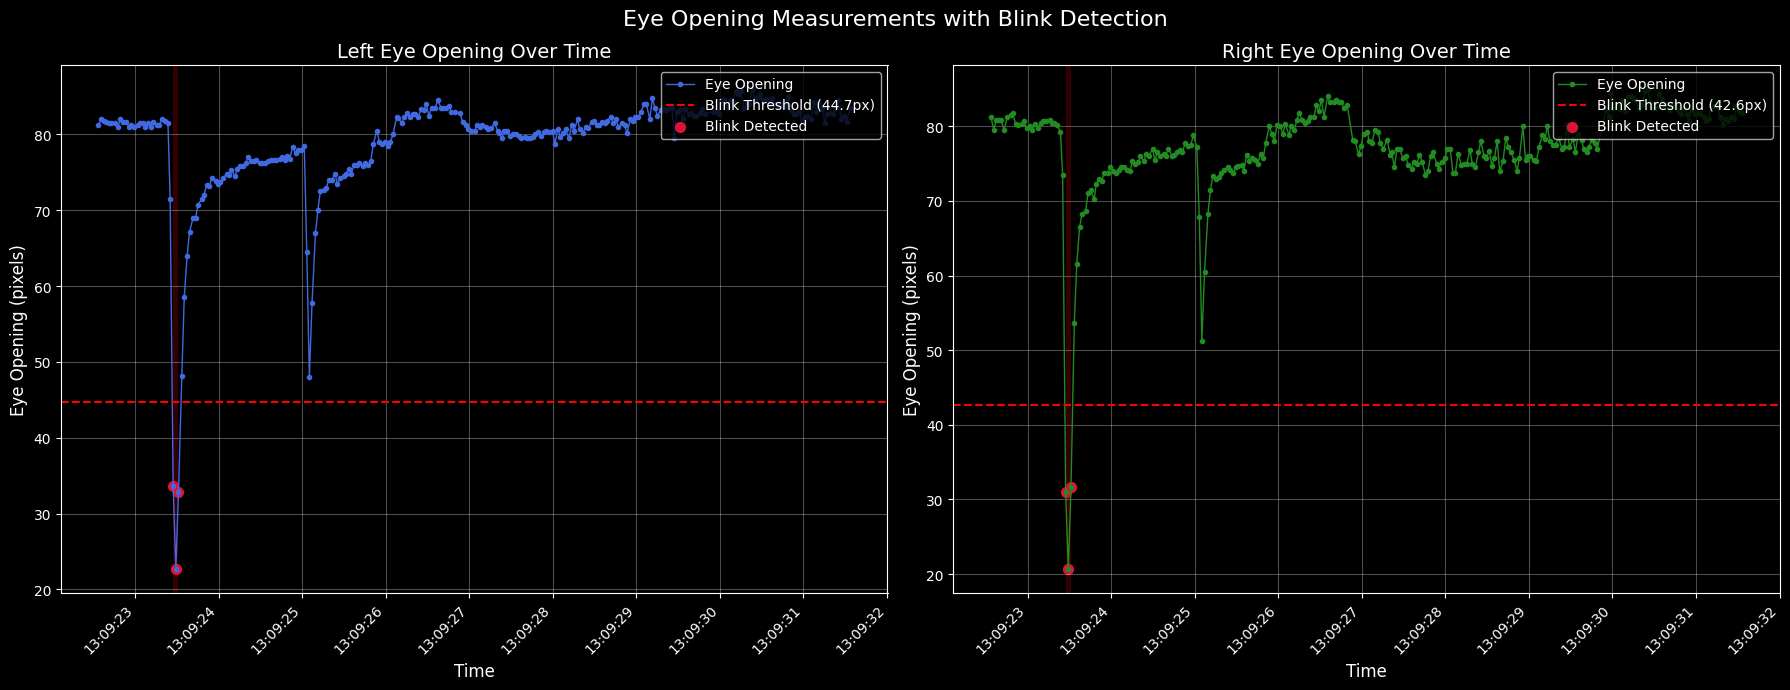

In [25]:
# Create time-series plots of eye opening with continuous lines but highlighted blinks
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import numpy as np

# Create figure and subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Calculate thresholds for both eyes
left_median = results['eye_opening_left'].median()
right_median = results['eye_opening_right'].median()
left_threshold = left_median * 0.55  # Using the same threshold value as in your code
right_threshold = right_median * 0.55

# --- Left Eye Plot ---
# Create a continuous line for all points
ax1.plot(results['timestamp'], results['eye_opening_left'], 
         '-o', color='royalblue', markersize=3, linewidth=1, label='Eye Opening')

# Add a horizontal line for the threshold
ax1.axhline(y=left_threshold, color='red', linestyle='--', linewidth=1.5, 
           label=f'Blink Threshold ({left_threshold:.1f}px)')

# Highlight the blink sections with different styling
blink_mask = results['blink_left']
if blink_mask.any():
    ax1.scatter(results.loc[blink_mask, 'timestamp'], 
                results.loc[blink_mask, 'eye_opening_left'],
                color='crimson', s=50, marker='o', label='Blink Detected')
    
    # Add shading for blink regions
    for idx in np.where(np.diff(np.concatenate(([0], blink_mask.astype(int), [0]))))[0].reshape(-1, 2):
        if idx[1] > idx[0]:  # Ensure valid range
            ax1.axvspan(results.iloc[idx[0]]['timestamp'], 
                        results.iloc[idx[1]-1]['timestamp'], 
                        alpha=0.2, color='red', lw=0)

# Customize left subplot appearance
ax1.set_title('Left Eye Opening Over Time', fontsize=14)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Eye Opening (pixels)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right')

# Format x-axis to show time better
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# --- Right Eye Plot ---
# Create a continuous line for all points
ax2.plot(results['timestamp'], results['eye_opening_right'], 
         '-o', color='forestgreen', markersize=3, linewidth=1, label='Eye Opening')

# Add a horizontal line for the threshold
ax2.axhline(y=right_threshold, color='red', linestyle='--', linewidth=1.5, 
           label=f'Blink Threshold ({right_threshold:.1f}px)')

# Highlight the blink sections with different styling
blink_mask = results['blink_right']
if blink_mask.any():
    ax2.scatter(results.loc[blink_mask, 'timestamp'], 
                results.loc[blink_mask, 'eye_opening_right'],
                color='crimson', s=50, marker='o', label='Blink Detected')
    
    # Add shading for blink regions
    for idx in np.where(np.diff(np.concatenate(([0], blink_mask.astype(int), [0]))))[0].reshape(-1, 2):
        if idx[1] > idx[0]:  # Ensure valid range
            ax2.axvspan(results.iloc[idx[0]]['timestamp'], 
                        results.iloc[idx[1]-1]['timestamp'], 
                        alpha=0.2, color='red', lw=0)

# Customize right subplot appearance
ax2.set_title('Right Eye Opening Over Time', fontsize=14)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('Eye Opening (pixels)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right')

# Format x-axis to show time better
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add a common suptitle
plt.suptitle('Eye Opening Measurements with Blink Detection', fontsize=16, y=0.98)

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [26]:
# Read the protocol CSV file into a pandas DataFrame
flash_df = pd.read_csv(protocol_path)

flash_df['time'] = pd.to_datetime(flash_df['time'])

# Display the first few rows of the DataFrame
flash_df.head()

time     event
0 2024-08-29 13:09:26.856   FlashOn
1 2024-08-29 13:09:29.919  FlashOff

In [27]:
# Extract the timestamp when the flash turns on
flash_on_timestamp = flash_df.loc[flash_df['event'] == 'FlashOn', 'time'].iloc[0]

# Extract the timestamp when the flash turns off
flash_off_timestamp = flash_df.loc[flash_df['event'] == 'FlashOff', 'time'].iloc[0]

def mark_frames_with_flash(row: pd.Series, flash_on: pd.Timestamp, flash_off: pd.Timestamp) -> bool:
    """ Mark frames with flash by checking if the eye opening is below the threshold. """
    # Extract the flash on and off timestamps
    timestamp = row['timestamp']
    
    # Check if the timestamp is within the flash on and off timestamps
    return flash_on <= timestamp <= flash_off

results['flash'] = results.apply(mark_frames_with_flash, axis=1, flash_on=flash_on_timestamp, flash_off=flash_off_timestamp)
results

id               timestamp                              center_left  \
0    1852 2024-08-29 13:09:22.559              (292.79998779296875, 967.0)   
1    1853 2024-08-29 13:09:22.592                           (294.0, 965.0)   
2    1854 2024-08-29 13:09:22.621  (295.29998779296875, 965.2999877929688)   
3    1855 2024-08-29 13:09:22.652               (296.0, 962.7999877929688)   
4    1856 2024-08-29 13:09:22.682              (295.79998779296875, 961.0)   
..    ...                     ...                                      ...   
263  2115 2024-08-29 13:09:31.414              (311.79998779296875, 962.0)   
264  2116 2024-08-29 13:09:31.454                           (310.5, 961.0)   
265  2117 2024-08-29 13:09:31.484  (307.79998779296875, 958.7999877929688)   
266  2118 2024-08-29 13:09:31.516               (303.0, 958.2999877929688)   
267  2119 2024-08-29 13:09:31.556                           (297.5, 957.0)   

                               center_right  \
0    (774.2999877929688, 973.2999877929688)   
1                (775.2999877929688, 971.0)   
2                            (776.0, 970.0)   
3    (776.2999877929688, 968.7999877929688)   
4                (776.5, 967.7999877929688)   
..                                      ...   
263  (786.7999877929688, 964.2999877929688)   
264  (784.7999877929688, 962.2999877929688)   
265              (781.7999877929688, 960.0)   
266                          (776.5, 958.0)   
267              (770.7999877929688, 956.5)   

                                     points_pupil_left  \
0    [(317.0, 966.7999877929688), (313.299987792968...   
1    [(317.79998779296875, 965.0), (313.79998779296...   
2    [(318.0, 965.2999877929688), (314.299987792968...   
3    [(318.29998779296875, 962.7999877929688), (314...   
4    [(319.5, 961.0), (315.5, 973.5), (295.79998779...   
..                                                 ...   
263  [(328.0, 962.2999877929688), (325.5, 970.29998...   
264  [(326.5, 961.2999877929688), (324.0, 969.0), (...   
265  [(324.5, 958.7999877929688), (321.799987792968...   
266  [(319.5, 958.2999877929688), (317.0, 966.29998...   
267  [(313.79998779296875, 957.0), (311.29998779296...   

                                      points_iris_left  \
0    [(241.0, 967.0), (248.3000030517578, 991.29998...   
1    [(242.5, 965.0), (249.0, 989.2999877929688), (...   
2    [(243.3000030517578, 965.5), (250.0, 988.79998...   
3    [(243.8000030517578, 962.7999877929688), (250....   
4    [(244.0, 961.2999877929688), (251.0, 986.0), (...   
..                                                 ...   
263  [(261.5, 962.0), (267.5, 985.0), (311.5, 1006....   
264  [(260.0, 961.0), (266.0, 983.5), (310.5, 1004....   
265  [(257.5, 958.7999877929688), (263.799987792968...   
266  [(252.8000030517578, 958.2999877929688), (258....   
267  [(247.0, 957.0), (253.3000030517578, 979.5), (...   

                                    points_sclera_left  \
0    [(196.3000030517578, 977.7999877929688), (219....   
1    [(197.0, 977.0), (219.8000030517578, 997.79998...   
2    [(198.5, 976.2999877929688), (220.800003051757...   
3    [(199.8000030517578, 974.5), (222.0, 995.29998...   
4    [(200.3000030517578, 971.7999877929688), (222....   
..                                                 ...   
263  [(217.5, 973.7999877929688), (236.800003051757...   
264  [(217.8000030517578, 971.5), (238.0, 994.0), (...   
265  [(216.3000030517578, 969.2999877929688), (235....   
266  [(210.5, 968.5), (230.5, 988.5), (261.0, 1000....   
267  [(205.5, 967.2999877929688), (224.0, 990.0), (...   

                                    points_pupil_right  \
0    [(750.0, 973.0), (754.0, 985.5), (774.29998779...   
1    [(751.7999877929688, 971.0), (755.799987792968...   
2    [(752.0, 970.0), (755.7999877929688, 982.29998...   
3    [(752.2999877929688, 968.7999877929688), (756....   
4    [(752.7999877929688, 968.0), (756.5, 980.29998...   
..                                                 ...   
263  [(7

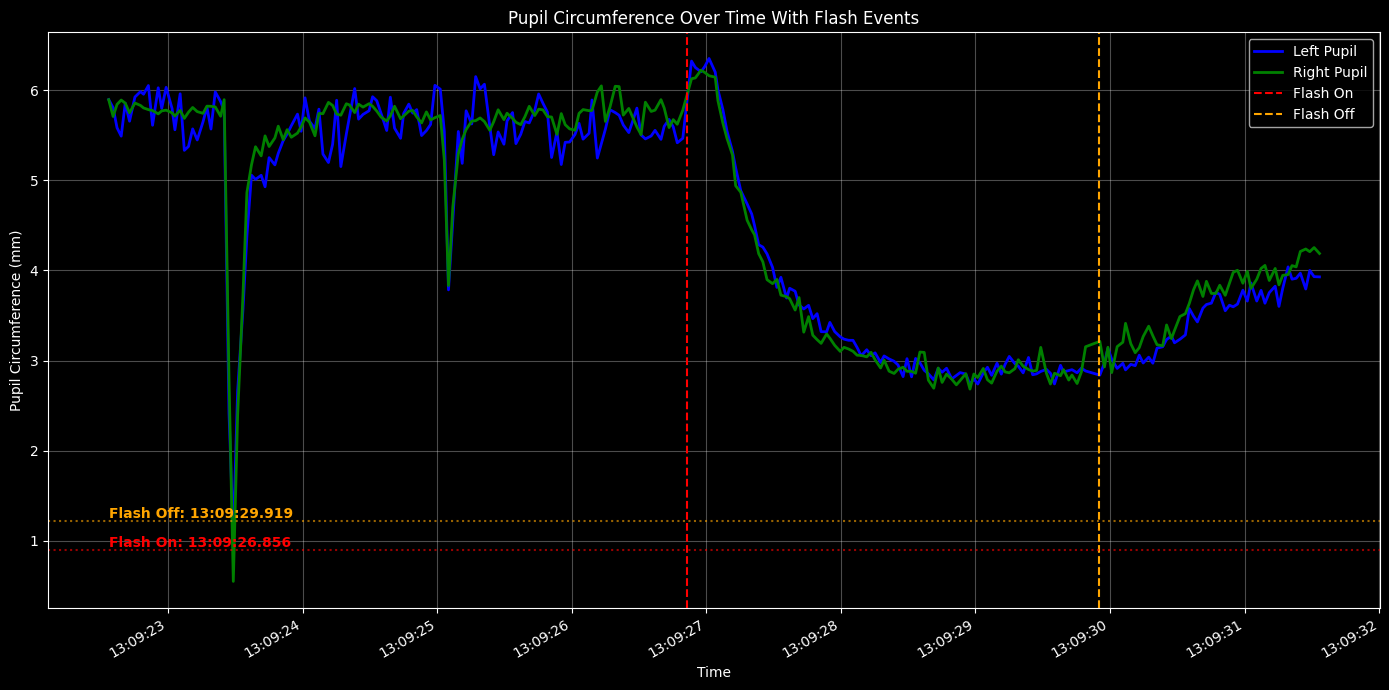

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a time series plot of pupil circumference for both eyes
fig, ax = plt.subplots(figsize=(14, 7))

# Plot pupil circumference for left and right eyes
ax.plot(results['timestamp'], results['circumference_mm_pupil_left'], 
        label='Left Pupil', color='blue', linewidth=2)
ax.plot(results['timestamp'], results['circumference_mm_pupil_right'], 
        label='Right Pupil', color='green', linewidth=2)

# Add vertical lines at flash on/off timestamps
ax.axvline(x=flash_on_timestamp, color='red', linestyle='--', linewidth=1.5, 
          label='Flash On')
ax.axvline(x=flash_off_timestamp, color='orange', linestyle='--', linewidth=1.5, 
          label='Flash Off')

# Add horizontal reference lines with timestamp annotations
y_min, y_max = ax.get_ylim()
y_range = y_max - y_min
flash_on_level = y_min + y_range * 0.1  # Position near bottom
flash_off_level = y_min + y_range * 0.15  # Position slightly higher

# Add horizontal lines spanning the graph at specific y-positions
ax.axhline(y=flash_on_level, color='red', linestyle=':', alpha=0.6)
ax.axhline(y=flash_off_level, color='orange', linestyle=':', alpha=0.6)

# Add text annotations for the horizontal lines
ax.text(results['timestamp'].iloc[0], flash_on_level, 
        f'Flash On: {flash_on_timestamp.strftime("%H:%M:%S.%f")[:-3]}', 
        color='red', fontweight='bold', va='bottom')
ax.text(results['timestamp'].iloc[0], flash_off_level, 
        f'Flash Off: {flash_off_timestamp.strftime("%H:%M:%S.%f")[:-3]}', 
        color='orange', fontweight='bold', va='bottom')

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Pupil Circumference (mm)')
ax.set_title('Pupil Circumference Over Time With Flash Events')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')

# Format x-axis to show time better
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [29]:
flash_on_timestamp

Timestamp('2024-08-29 13:09:26.856000')

In [30]:
type(flash_on_timestamp)

pandas._libs.tslibs.timestamps.Timestamp

In [31]:
boolean_mask_pre_flash_frames = (results['timestamp'] < flash_on_timestamp)
boolean_mask_pre_flash_frames

0       True
1       True
2       True
3       True
4       True
       ...  
263    False
264    False
265    False
266    False
267    False
Name: timestamp, Length: 268, dtype: bool

In [32]:
baseline_end_idx = results.loc[boolean_mask_pre_flash_frames, ['id']]
baseline_end_idx

id
0    1852
1    1853
2    1854
3    1855
4    1856
..    ...
124  1976
125  1977
126  1978
127  1979
128  1980

[129 rows x 1 columns]

In [33]:
baseline_end_idx = baseline_end_idx.index.max().astype(int)

In [34]:
baseline_window = 20
baseline_start_idx = max(0, baseline_end_idx - baseline_window)
baseline_start_idx

np.int64(108)

In [35]:
# Calculate baseline values (mean of window before flash)
baseline_left = results.loc[baseline_start_idx:baseline_end_idx, 'circumference_mm_pupil_left'].median()
baseline_right = results.loc[baseline_start_idx:baseline_end_idx, 'circumference_mm_pupil_right'].median()
baseline_left, baseline_right

(np.float64(5.566358709015732), np.float64(5.776729602917622))

In [36]:
std_baseline_left = results.loc[baseline_start_idx:baseline_end_idx, 'circumference_mm_pupil_left'].std()
std_baseline_right = results.loc[baseline_start_idx:baseline_end_idx, 'circumference_mm_pupil_right'].std()
std_baseline_left, std_baseline_right

(np.float64(0.15520483437594482), np.float64(0.15521113305920084))

In [37]:
threshold_std_left = baseline_left - 3 * std_baseline_left
threshold_std_right = baseline_right - 3 * std_baseline_right
threshold_std_left, threshold_std_right

(np.float64(5.100744205887898), np.float64(5.31109620374002))

In [38]:
threshold_pct=5
# Calculate threshold values (x% decrease from baseline)
threshold_left = baseline_left * (1 - threshold_pct/100)
threshold_right = baseline_right * (1 - threshold_pct/100)
threshold_left, threshold_right

(np.float64(5.288040773564945), np.float64(5.487893122771741))

In [39]:
# Find first post-flash frame where value drops below threshold
post_flash = results[results['timestamp'] >= flash_on_timestamp]
    
response_left_idx = post_flash[post_flash['circumference_mm_pupil_left'] < threshold_left].index.min()
response_right_idx = post_flash[post_flash['circumference_mm_pupil_right'] < threshold_right].index.min()
response_std_left_idx = post_flash[post_flash['circumference_mm_pupil_left'] < threshold_std_left].index.min()
response_std_right_idx = post_flash[post_flash['circumference_mm_pupil_right'] < threshold_std_right].index.min()
response_left_idx, response_right_idx, response_std_left_idx, response_std_right_idx

(np.int64(139), np.int64(137), np.int64(140), np.int64(138))

In [40]:
# Calculate latency in seconds
latency_left = (results.loc[response_std_left_idx, 'timestamp'] - flash_on_timestamp).total_seconds()
latency_right = (results.loc[response_std_right_idx, 'timestamp'] - flash_on_timestamp).total_seconds()
latency_left, latency_right

(0.4, 0.338)

In [41]:
# Calculate latency in seconds
latency_left = (results.loc[response_left_idx, 'timestamp'] - flash_on_timestamp).total_seconds()
latency_right = (results.loc[response_right_idx, 'timestamp'] - flash_on_timestamp).total_seconds()
latency_left, latency_right

(0.362, 0.297)

In [54]:
def calculate_latency(results, flash_on_timestamp, baseline_window=20, threshold_pct=5):
    """
    Calculate pupil response latency using threshold crossing method.
    
    Args:
        results_df: DataFrame with 'timestamp' and 'circumference_mm_pupil_left/right'
        flash_on_timestamp: Timestamp when flash turned on
        baseline_window: Number of frames before flash to establish baseline
        threshold_pct: Percentage decrease from baseline to consider as response
        
    Returns:
        latency_left, latency_right: Latency times in seconds for both eyes
    """
    # Create mask for pre-flash baseline period
    boolean_mask_pre_flash_frames = (results['timestamp'] < flash_on_timestamp)
    baseline_end_idx = results.loc[boolean_mask_pre_flash_frames, ['id']].index.max().astype(int)
    baseline_start_idx = max(0, baseline_end_idx - baseline_window)
    
    # Calculate baseline values (mean of window before flash)
    baseline_left = results.loc[baseline_start_idx:baseline_end_idx, 'circumference_mm_pupil_left'].mean()
    baseline_right = results.loc[baseline_start_idx:baseline_end_idx, 'circumference_mm_pupil_right'].mean()
    
    std_baseline_left = results.loc[baseline_start_idx:baseline_end_idx, 'circumference_mm_pupil_left'].std()
    std_baseline_right = results.loc[baseline_start_idx:baseline_end_idx, 'circumference_mm_pupil_right'].std()
    
    def calculate_adaptive_threshold(baseline, baseline_std):
        # Calculate coefficient of variation
        cv = baseline_std / baseline
        
        print(f"Baseline: {baseline}, Std: {baseline_std}, CV: {cv}")
        # Choose appropriate multiplier based on signal quality
        if cv < 0.01:  # Very stable baseline (<1% variation)
            multiplier = 2.0
        elif cv < 0.05:  # Moderately stable (2-5% variation)
            multiplier = 2.5
        else:  # Noisy baseline (>5% variation)
            multiplier = 3.0
            
        # Calculate the threshold
        threshold = baseline - multiplier * baseline_std
        print(f"Adaptive Threshold: {threshold}")
        return threshold
    
    # Calculate threshold values (x% decrease from baseline)
    # threshold_left = baseline_left * (1 - threshold_pct/100)
    # threshold_right = baseline_right * (1 - threshold_pct/100)
    
    adaptive_threshold_left = calculate_adaptive_threshold(baseline_left, std_baseline_left)
    adaptive_threshold_right = calculate_adaptive_threshold(baseline_right, std_baseline_right)
        
    # Find first post-flash frame where value drops below threshold
    post_flash = results[results['timestamp'] >= flash_on_timestamp]
    
    response_left_idx = post_flash[post_flash['circumference_mm_pupil_left'] < adaptive_threshold_left].index.min()
    response_right_idx = post_flash[post_flash['circumference_mm_pupil_right'] < adaptive_threshold_right].index.min()
    
    # Calculate latency in seconds
    latency_left = (results.loc[response_left_idx, 'timestamp'] - flash_on_timestamp).total_seconds()
    latency_right = (results.loc[response_right_idx, 'timestamp'] - flash_on_timestamp).total_seconds()
    
    return latency_left, latency_right, response_left_idx, response_right_idx

latency_left, latency_right, response_left_idx, response_right_idx = calculate_latency(results, flash_on_timestamp,baseline_window=20)
latency_left, latency_right, response_left_idx, response_right_idx

Baseline: 5.5793202768879535, Std: 0.15520483437594482, CV: 0.027817875058879993
Adaptive Threshold: 5.191308190948091
Baseline: 5.780948844637921, Std: 0.15521113305920084, CV: 0.02684872972075611
Adaptive Threshold: 5.392921011989919


(0.362, 0.338, np.int64(139), np.int64(138))

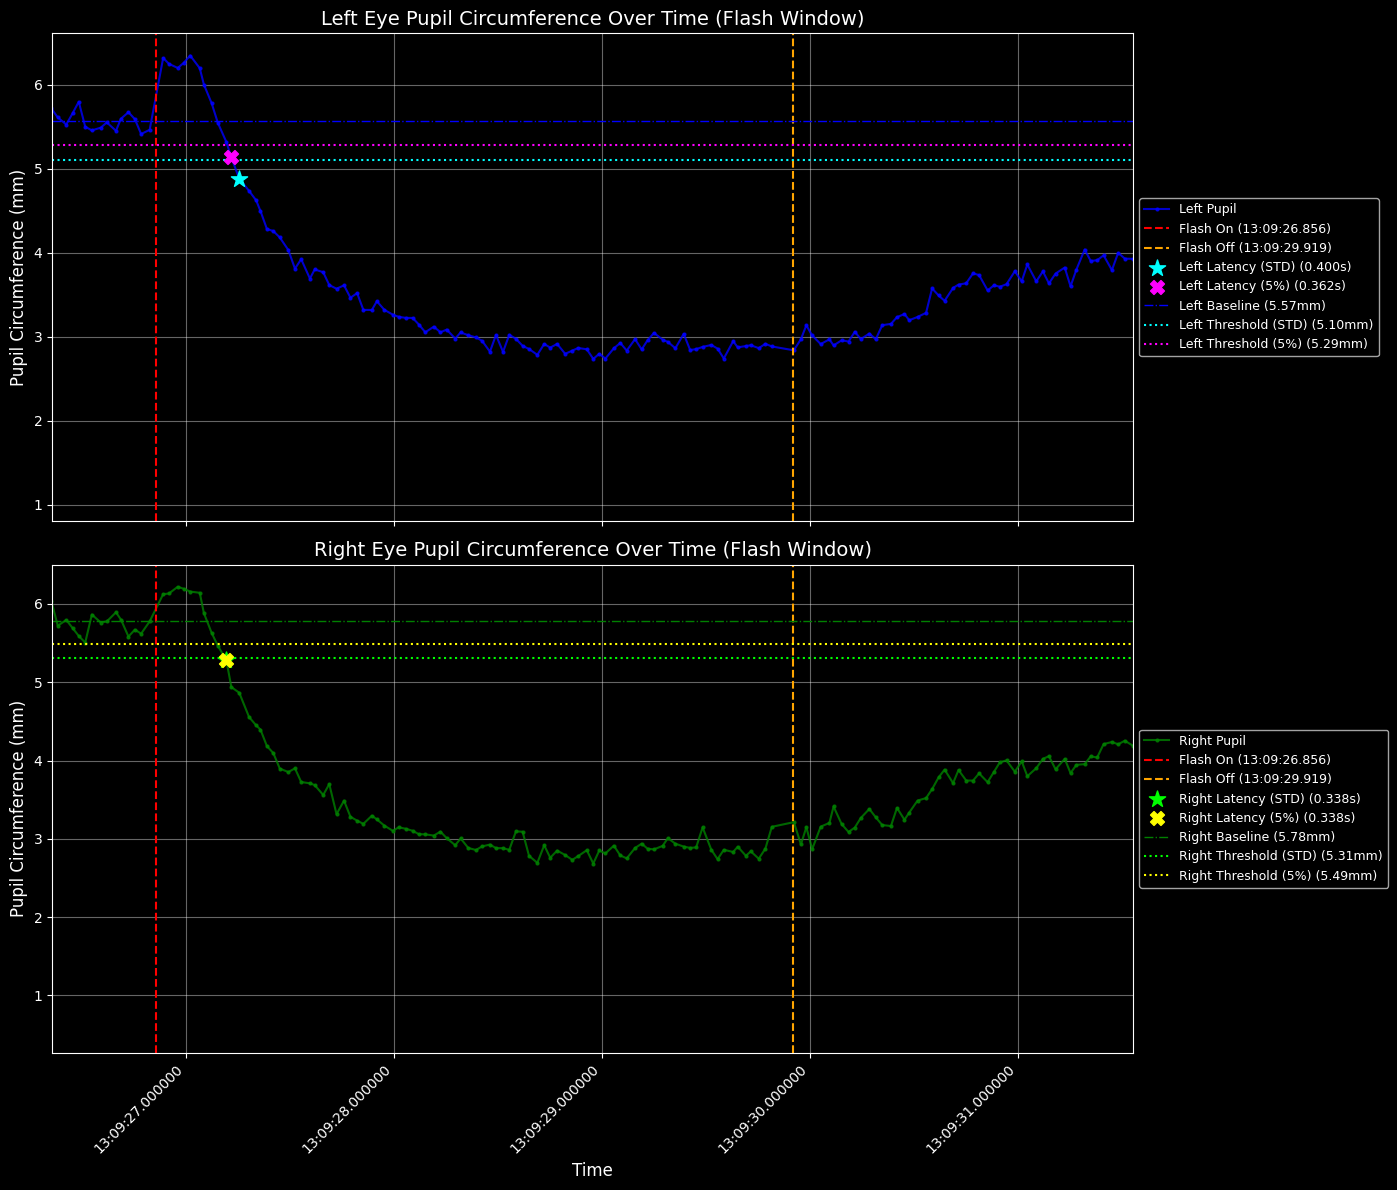

In [55]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Define the time window for the plot
# Start slightly before the flash and end at the last data point
plot_start_time = flash_on_timestamp - pd.Timedelta(seconds=0.5) # Start 0.5 seconds before flash
plot_end_time = results['timestamp'].iloc[-1]

# Create a figure with two subplots (one for each eye)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True) # Share x-axis

# --- Left Eye Plot (ax1) ---
ax1.plot(results['timestamp'], results['circumference_mm_pupil_left'],
         label='Left Pupil', color='blue', linewidth=1.5, alpha=0.8, marker='.', markersize=4)

# Vertical Lines (Flash & Latency)
ax1.axvline(x=flash_on_timestamp, color='red', linestyle='--', linewidth=1.5,
            label=f'Flash On ({flash_on_timestamp.strftime("%H:%M:%S.%f")[:-3]})')
ax1.axvline(x=flash_off_timestamp, color='orange', linestyle='--', linewidth=1.5,
            label=f'Flash Off ({flash_off_timestamp.strftime("%H:%M:%S.%f")[:-3]})')

# Latency Point (STD)
latency_timestamp_left_std = results.loc[response_std_left_idx, 'timestamp']
latency_value_left_std = results.loc[response_std_left_idx, 'circumference_mm_pupil_left']
latency_left_std = (latency_timestamp_left_std - flash_on_timestamp).total_seconds() # Recalculate for clarity
ax1.scatter([latency_timestamp_left_std], [latency_value_left_std], color='cyan', s=150, marker='*', zorder=5,
            label=f'Left Latency (STD) ({latency_left_std:.3f}s)')

# Latency Point (Percentage)
latency_timestamp_left_pct = results.loc[response_left_idx, 'timestamp']
latency_value_left_pct = results.loc[response_left_idx, 'circumference_mm_pupil_left']
latency_left_pct = (latency_timestamp_left_pct - flash_on_timestamp).total_seconds() # Recalculate for clarity
ax1.scatter([latency_timestamp_left_pct], [latency_value_left_pct], color='magenta', s=100, marker='X', zorder=5,
            label=f'Left Latency ({threshold_pct}%) ({latency_left_pct:.3f}s)')


# Horizontal Lines (Baseline & Thresholds)
ax1.axhline(y=baseline_left, color='blue', linestyle='-.', linewidth=1,
            label=f'Left Baseline ({baseline_left:.2f}mm)')
ax1.axhline(y=threshold_std_left, color='cyan', linestyle=':', linewidth=1.5,
            label=f'Left Threshold (STD) ({threshold_std_left:.2f}mm)')
ax1.axhline(y=threshold_left, color='magenta', linestyle=':', linewidth=1.5,
            label=f'Left Threshold ({threshold_pct}%) ({threshold_left:.2f}mm)')

# Customization
ax1.set_ylabel('Pupil Circumference (mm)', fontsize=12)
ax1.set_title('Left Eye Pupil Circumference Over Time (Flash Window)', fontsize=14)
ax1.grid(True, alpha=0.4)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
ax1.set_xlim(plot_start_time, plot_end_time)


# --- Right Eye Plot (ax2) ---
ax2.plot(results['timestamp'], results['circumference_mm_pupil_right'],
         label='Right Pupil', color='green', linewidth=1.5, alpha=0.8, marker='.', markersize=4)

# Vertical Lines (Flash & Latency)
ax2.axvline(x=flash_on_timestamp, color='red', linestyle='--', linewidth=1.5,
            label=f'Flash On ({flash_on_timestamp.strftime("%H:%M:%S.%f")[:-3]})')
ax2.axvline(x=flash_off_timestamp, color='orange', linestyle='--', linewidth=1.5,
            label=f'Flash Off ({flash_off_timestamp.strftime("%H:%M:%S.%f")[:-3]})')

# Latency Point (STD)
latency_timestamp_right_std = results.loc[response_std_right_idx, 'timestamp']
latency_value_right_std = results.loc[response_std_right_idx, 'circumference_mm_pupil_right']
latency_right_std = (latency_timestamp_right_std - flash_on_timestamp).total_seconds() # Recalculate for clarity
ax2.scatter([latency_timestamp_right_std], [latency_value_right_std], color='lime', s=150, marker='*', zorder=5,
            label=f'Right Latency (STD) ({latency_right_std:.3f}s)')

# Latency Point (Percentage)
latency_timestamp_right_pct = results.loc[response_right_idx, 'timestamp']
latency_value_right_pct = results.loc[response_right_idx, 'circumference_mm_pupil_right']
latency_right_pct = (latency_timestamp_right_pct - flash_on_timestamp).total_seconds() # Recalculate for clarity
ax2.scatter([latency_timestamp_right_pct], [latency_value_right_pct], color='yellow', s=100, marker='X', zorder=5,
            label=f'Right Latency ({threshold_pct}%) ({latency_right_pct:.3f}s)')


# Horizontal Lines (Baseline & Thresholds)
ax2.axhline(y=baseline_right, color='green', linestyle='-.', linewidth=1,
            label=f'Right Baseline ({baseline_right:.2f}mm)')
ax2.axhline(y=threshold_std_right, color='lime', linestyle=':', linewidth=1.5,
            label=f'Right Threshold (STD) ({threshold_std_right:.2f}mm)')
ax2.axhline(y=threshold_right, color='yellow', linestyle=':', linewidth=1.5,
            label=f'Right Threshold ({threshold_pct}%) ({threshold_right:.2f}mm)')

# Customization
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('Pupil Circumference (mm)', fontsize=12)
ax2.set_title('Right Eye Pupil Circumference Over Time (Flash Window)', fontsize=14)
ax2.grid(True, alpha=0.4)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
ax2.set_xlim(plot_start_time, plot_end_time)

# Format x-axis for both plots
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S.%f'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Adjust layout to prevent labels overlapping
plt.tight_layout(rect=[0, 0, 0.88, 1]) # Leave space on the right for the legends

# Show the plot
plt.show()

In [56]:
window_size=10
std_threshold=0.05

In [57]:
flash_on_frames = results.loc[
    (results['flash'] == True),
    ['timestamp', 'circumference_mm_pupil_left', 'circumference_mm_pupil_right']
].copy()

flash_on_frames

timestamp  circumference_mm_pupil_left  circumference_mm_pupil_right
129 2024-08-29 13:09:26.890                     6.320772                      6.125143
130 2024-08-29 13:09:26.918                     6.250604                      6.134056
131 2024-08-29 13:09:26.960                     6.201943                      6.219570
132 2024-08-29 13:09:26.988                     6.260036                      6.195181
133 2024-08-29 13:09:27.020                     6.349941                      6.158435
..                      ...                          ...                           ...
213 2024-08-29 13:09:29.693                     2.889379                      2.784171
214 2024-08-29 13:09:29.717                     2.899646                      2.839591
215 2024-08-29 13:09:29.755                     2.864969                      2.746043
216 2024-08-29 13:09:29.787                     2.916701                      2.874947
217 2024-08-29 13:09:29.818                     2.885205                      3.153560

[89 rows x 3 columns]

In [58]:
    # Calculate rolling standard deviation
flash_on_frames['rolling_std_left'] = flash_on_frames['circumference_mm_pupil_left'].rolling(window_size).std()
flash_on_frames['rolling_std_right'] = flash_on_frames['circumference_mm_pupil_right'].rolling(window_size).std()

flash_on_frames

timestamp  circumference_mm_pupil_left  circumference_mm_pupil_right  rolling_std_left  rolling_std_right
129 2024-08-29 13:09:26.890                     6.320772                      6.125143               NaN                NaN
130 2024-08-29 13:09:26.918                     6.250604                      6.134056               NaN                NaN
131 2024-08-29 13:09:26.960                     6.201943                      6.219570               NaN                NaN
132 2024-08-29 13:09:26.988                     6.260036                      6.195181               NaN                NaN
133 2024-08-29 13:09:27.020                     6.349941                      6.158435               NaN                NaN
..                      ...                          ...                           ...               ...                ...
213 2024-08-29 13:09:29.693                     2.889379                      2.784171          0.075148           0.107388
214 2024-08-29 13:09:29.717                     2.899646                      2.839591          0.053886           0.107798
215 2024-08-29 13:09:29.755                     2.864969                      2.746043          0.053145           0.114929
216 2024-08-29 13:09:29.787                     2.916701                      2.874947          0.054518           0.114568
217 2024-08-29 13:09:29.818                     2.885205                      3.153560          0.054567           0.116521

[89 rows x 5 columns]

In [59]:
# Skip initial NaN values from rolling window
valid_data = flash_on_frames.iloc[window_size-1:]
valid_data

timestamp  circumference_mm_pupil_left  circumference_mm_pupil_right  rolling_std_left  rolling_std_right
138 2024-08-29 13:09:27.194                     5.320082                      5.281422          0.356474           0.342767
139 2024-08-29 13:09:27.218                     5.135584                      4.938526          0.435116           0.453007
140 2024-08-29 13:09:27.256                     4.883923                      4.866222          0.520798           0.522780
141 2024-08-29 13:09:27.303                     4.738203                      4.556988          0.586969           0.591418
142 2024-08-29 13:09:27.337                     4.626496                      4.450118          0.616321           0.624038
..                      ...                          ...                           ...               ...                ...
213 2024-08-29 13:09:29.693                     2.889379                      2.784171          0.075148           0.107388
214 2024-08-29 13:09:29.717                     2.899646                      2.839591          0.053886           0.107798
215 2024-08-29 13:09:29.755                     2.864969                      2.746043          0.053145           0.114929
216 2024-08-29 13:09:29.787                     2.916701                      2.874947          0.054518           0.114568
217 2024-08-29 13:09:29.818                     2.885205                      3.153560          0.054567           0.116521

[80 rows x 5 columns]

In [60]:
    # Find first point where std is below threshold (pupil stable)
stable_left_idx = valid_data[valid_data['rolling_std_left'] < std_threshold].index.min()
stable_right_idx = valid_data[valid_data['rolling_std_right'] < std_threshold].index.min()
stable_left_idx, stable_right_idx

(np.int64(190), np.int64(170))

In [61]:

# Calculate stabilization time and value
if pd.notnull(stable_left_idx):
    stable_time_left = (flash_on_frames.loc[stable_left_idx, 'timestamp'] - flash_on_timestamp).total_seconds()
    stable_value_left = flash_on_frames.loc[stable_left_idx:, 'circumference_mm_pupil_left'].mean()
else:
    stable_time_left, stable_value_left = None, None
    
if pd.notnull(stable_right_idx):
    stable_time_right = (flash_on_frames.loc[stable_right_idx, 'timestamp'] - flash_on_timestamp).total_seconds()
    stable_value_right = flash_on_frames.loc[stable_right_idx:, 'circumference_mm_pupil_right'].mean()
else:
    stable_time_right, stable_value_right = None, None
    
stable_time_left, stable_value_left, stable_time_right, stable_value_right

(2.072,
 np.float64(2.8836023714325942),
 1.3980000000000001,
 np.float64(2.8772561885934977))

In [62]:
def find_stabilization(results_df, flash_on_timestamp, response_left_idx=None, response_right_idx=None, 
                       window_size=10, std_threshold=0.05):
    """
    Determine when pupil size stabilizes after constriction and the stabilized value.
    
    Args:
        results_df: DataFrame with pupil measurements
        flash_on_timestamp: When flash turned on
        response_left_idx: Index when left eye started responding (from calculate_latency)
        response_right_idx: Index when right eye started responding (from calculate_latency)
        window_size: Size of rolling window to check for stability
        std_threshold: Maximum standard deviation to consider stable
        
    Returns:
        Dict with stabilization time and values for both eyes, including both the first stable
        point and the point closest to the mean stable value
    """
    # Get the response timestamps if indices are provided
    response_left_timestamp = None
    response_right_timestamp = None
    
    if response_left_idx is not None and response_left_idx in results_df.index:
        response_left_timestamp = results_df.loc[response_left_idx, 'timestamp']
    
    if response_right_idx is not None and response_right_idx in results_df.index:
        response_right_timestamp = results_df.loc[response_right_idx, 'timestamp']
    
    # Filter for frames during flash and after response onset for each eye
    flash_on_frames_left = results_df.loc[
        (results_df['flash'] == True) & 
        (response_left_timestamp is None or results_df['timestamp'] >= response_left_timestamp),
        ['timestamp', 'circumference_mm_pupil_left', 'circumference_mm_pupil_right']
    ].copy()
    
    flash_on_frames_right = results_df.loc[
        (results_df['flash'] == True) & 
        (response_right_timestamp is None or results_df['timestamp'] >= response_right_timestamp),
        ['timestamp', 'circumference_mm_pupil_left', 'circumference_mm_pupil_right']
    ].copy()
    
    # If no frames found, return None values
    if len(flash_on_frames_left) == 0 and len(flash_on_frames_right) == 0:
        return {
            'left': {'time': None, 'value': None, 'closest_match_time': None, 'closest_match_value': None},
            'right': {'time': None, 'value': None, 'closest_match_time': None, 'closest_match_value': None}
        }
    
    # Calculate rolling standard deviation for both eyes
    if len(flash_on_frames_left) > window_size:
        flash_on_frames_left['rolling_std_left'] = flash_on_frames_left['circumference_mm_pupil_left'].rolling(window_size).std()
        # Skip initial NaN values from rolling window
        valid_data_left = flash_on_frames_left.iloc[window_size-1:]
        # Find first point where std is below threshold (pupil stable)
        stable_left_idx = valid_data_left[valid_data_left['rolling_std_left'] < std_threshold].index.min()
    else:
        stable_left_idx = None
        
    if len(flash_on_frames_right) > window_size:
        flash_on_frames_right['rolling_std_right'] = flash_on_frames_right['circumference_mm_pupil_right'].rolling(window_size).std()
        # Skip initial NaN values from rolling window
        valid_data_right = flash_on_frames_right.iloc[window_size-1:]
        # Find first point where std is below threshold (pupil stable)
        stable_right_idx = valid_data_right[valid_data_right['rolling_std_right'] < std_threshold].index.min()
    else:
        stable_right_idx = None
    
    # For left eye
    stable_time_left = None
    stable_value_left = None
    closest_match_idx_left = None
    closest_match_time_left = None
    closest_match_value_left = None
    
    if pd.notnull(stable_left_idx):
        stable_time_left = (results_df.loc[stable_left_idx, 'timestamp'] - flash_on_timestamp).total_seconds()
        # Calculate the mean of all values from stability point onward
        stable_value_left = flash_on_frames_left.loc[stable_left_idx:, 'circumference_mm_pupil_left'].mean()
        
        # Find the point after stabilization where pupil size is closest to the mean stable value
        stable_subset = flash_on_frames_left.loc[stable_left_idx:]
        closest_match_idx_left = (stable_subset['circumference_mm_pupil_left'] - stable_value_left).abs().idxmin()
        closest_match_time_left = (results_df.loc[closest_match_idx_left, 'timestamp'] - flash_on_timestamp).total_seconds()
        closest_match_value_left = results_df.loc[closest_match_idx_left, 'circumference_mm_pupil_left']
    else:
        # If no point below threshold is found, use the point with minimum std
        if len(flash_on_frames_left) > window_size:
            min_std_left_idx = valid_data_left['rolling_std_left'].idxmin()
            if pd.notnull(min_std_left_idx):
                stable_time_left = (results_df.loc[min_std_left_idx, 'timestamp'] - flash_on_timestamp).total_seconds()
                stable_value_left = flash_on_frames_left.loc[min_std_left_idx:, 'circumference_mm_pupil_left'].mean()
                
                # Find closest match to mean value
                stable_subset = flash_on_frames_left.loc[min_std_left_idx:]
                closest_match_idx_left = (stable_subset['circumference_mm_pupil_left'] - stable_value_left).abs().idxmin()
                closest_match_time_left = (results_df.loc[closest_match_idx_left, 'timestamp'] - flash_on_timestamp).total_seconds()
                closest_match_value_left = results_df.loc[closest_match_idx_left, 'circumference_mm_pupil_left']
    
    # For right eye
    stable_time_right = None
    stable_value_right = None
    closest_match_idx_right = None
    closest_match_time_right = None
    closest_match_value_right = None
    
    if pd.notnull(stable_right_idx):
        stable_time_right = (results_df.loc[stable_right_idx, 'timestamp'] - flash_on_timestamp).total_seconds()
        stable_value_right = flash_on_frames_right.loc[stable_right_idx:, 'circumference_mm_pupil_right'].median()
        
        # Find the point after stabilization where pupil size is closest to the mean stable value
        stable_subset = flash_on_frames_right.loc[stable_right_idx:]
        closest_match_idx_right = (stable_subset['circumference_mm_pupil_right'] - stable_value_right).abs().idxmin()
        closest_match_time_right = (results_df.loc[closest_match_idx_right, 'timestamp'] - flash_on_timestamp).total_seconds()
        closest_match_value_right = results_df.loc[closest_match_idx_right, 'circumference_mm_pupil_right']
    else:
        # If no point below threshold is found, use the point with minimum std
        if len(flash_on_frames_right) > window_size:
            min_std_right_idx = valid_data_right['rolling_std_right'].idxmin()
            if pd.notnull(min_std_right_idx):
                stable_time_right = (results_df.loc[min_std_right_idx, 'timestamp'] - flash_on_timestamp).total_seconds()
                stable_value_right = flash_on_frames_right.loc[min_std_right_idx:, 'circumference_mm_pupil_right'].median()
                
                # Find closest match to mean value
                stable_subset = flash_on_frames_right.loc[min_std_right_idx:]
                closest_match_idx_right = (stable_subset['circumference_mm_pupil_right'] - stable_value_right).abs().idxmin()
                closest_match_time_right = (results_df.loc[closest_match_idx_right, 'timestamp'] - flash_on_timestamp).total_seconds()
                closest_match_value_right = results_df.loc[closest_match_idx_right, 'circumference_mm_pupil_right']
    
    return {
        'left': {
            'time': stable_time_left, 
            'value': stable_value_left,
            'closest_match_time': closest_match_time_left,
            'closest_match_value': closest_match_value_left
        },
        'right': {
            'time': stable_time_right, 
            'value': stable_value_right,
            'closest_match_time': closest_match_time_right,
            'closest_match_value': closest_match_value_right
        }
    }
    
stabilization_info = find_stabilization(results, flash_on_timestamp, response_left_idx, response_right_idx, 
                                         window_size=10, std_threshold=0.10)
stabilization_info

{'left': {'time': 1.3980000000000001,
  'value': np.float64(2.9004459704118912),
  'closest_match_time': 2.8609999999999998,
  'closest_match_value': np.float64(2.8996458317142166)},
 'right': {'time': 1.234,
  'value': np.float64(2.881398828568218),
  'closest_match_time': 1.635,
  'closest_match_value': np.float64(2.881398828568218)}}

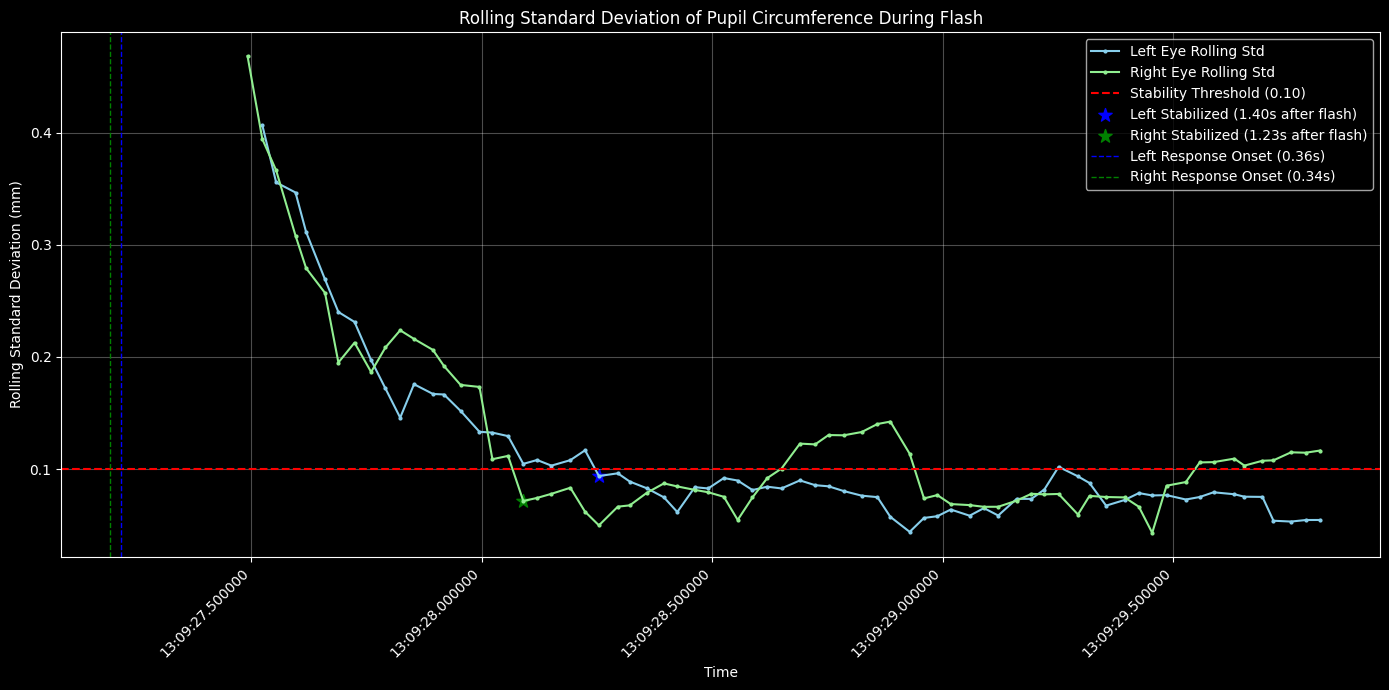

Left eye stabilized at 1.40s to 2.90mm
Right eye stabilized at 1.23s to 2.88mm


In [63]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

window_size=10
std_threshold=0.10

# Get stabilization info
stabilization_info = find_stabilization(results, flash_on_timestamp, response_left_idx, response_right_idx, 
                                        window_size=window_size, std_threshold=std_threshold)

# Extract stable points information
stable_time_left = stabilization_info['left']['time']
stable_value_left = stabilization_info['left']['value']
stable_time_right = stabilization_info['right']['time']
stable_value_right = stabilization_info['right']['value']

# Create flash frames dataframes for both eyes
flash_on_frames_left = results.loc[
    (results['flash'] == True) & 
    (results['timestamp'] >= results.loc[response_left_idx, 'timestamp']),
    ['timestamp', 'circumference_mm_pupil_left', 'circumference_mm_pupil_right']
].copy()

flash_on_frames_right = results.loc[
    (results['flash'] == True) & 
    (results['timestamp'] >= results.loc[response_right_idx, 'timestamp']),
    ['timestamp', 'circumference_mm_pupil_left', 'circumference_mm_pupil_right']
].copy()

# Calculate rolling standard deviations
flash_on_frames_left['rolling_std_left'] = flash_on_frames_left['circumference_mm_pupil_left'].rolling(window_size).std()
flash_on_frames_right['rolling_std_right'] = flash_on_frames_right['circumference_mm_pupil_right'].rolling(window_size).std()

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the rolling standard deviation for the left eye (skip NaN values)
valid_left = flash_on_frames_left['rolling_std_left'].notna()
ax.plot(flash_on_frames_left.loc[valid_left, 'timestamp'], 
        flash_on_frames_left.loc[valid_left, 'rolling_std_left'], 
        label='Left Eye Rolling Std', color='skyblue', marker='.', linestyle='-', markersize=4)

# Plot the rolling standard deviation for the right eye (skip NaN values)
valid_right = flash_on_frames_right['rolling_std_right'].notna()
ax.plot(flash_on_frames_right.loc[valid_right, 'timestamp'], 
        flash_on_frames_right.loc[valid_right, 'rolling_std_right'], 
        label='Right Eye Rolling Std', color='lightgreen', marker='.', linestyle='-', markersize=4)

# Add a horizontal line for the stability threshold
ax.axhline(y=std_threshold, color='red', linestyle='--', linewidth=1.5, 
        label=f'Stability Threshold ({std_threshold:.2f})')

# Mark stabilization points
if stable_time_left is not None:
    # Find the corresponding timestamp for stable_time_left
    stable_timestamp_left = flash_on_timestamp + pd.Timedelta(seconds=stable_time_left)
    # Find closest index in the dataframe
    closest_idx_left = flash_on_frames_left['timestamp'].sub(stable_timestamp_left).abs().idxmin()
    
    if closest_idx_left in flash_on_frames_left.index and 'rolling_std_left' in flash_on_frames_left.columns:
        std_at_stable_left = flash_on_frames_left.loc[closest_idx_left, 'rolling_std_left']
        if pd.notna(std_at_stable_left):
            ax.scatter(stable_timestamp_left, std_at_stable_left,
                    s=100, color='blue', marker='*', 
                    label=f'Left Stabilized ({stable_time_left:.2f}s after flash)')

if stable_time_right is not None:
    # Find the corresponding timestamp for stable_time_right
    stable_timestamp_right = flash_on_timestamp + pd.Timedelta(seconds=stable_time_right)
    # Find closest index in the dataframe
    closest_idx_right = flash_on_frames_right['timestamp'].sub(stable_timestamp_right).abs().idxmin()
    
    if closest_idx_right in flash_on_frames_right.index and 'rolling_std_right' in flash_on_frames_right.columns:
        std_at_stable_right = flash_on_frames_right.loc[closest_idx_right, 'rolling_std_right']
        if pd.notna(std_at_stable_right):
            ax.scatter(stable_timestamp_right, std_at_stable_right,
                    s=100, color='green', marker='*', 
                    label=f'Right Stabilized ({stable_time_right:.2f}s after flash)')

# Add vertical lines for response onset
response_left_timestamp = results.loc[response_left_idx, 'timestamp']
response_right_timestamp = results.loc[response_right_idx, 'timestamp']

ax.axvline(x=response_left_timestamp, color='blue', linestyle='--', linewidth=1, 
          label=f'Left Response Onset ({latency_left:.2f}s)')
ax.axvline(x=response_right_timestamp, color='green', linestyle='--', linewidth=1, 
          label=f'Right Response Onset ({latency_right:.2f}s)')

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Rolling Standard Deviation (mm)')
ax.set_title('Rolling Standard Deviation of Pupil Circumference During Flash')
ax.grid(True, alpha=0.3)
ax.legend()

# Format the x-axis to show time clearly
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S.%f'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Print stabilization information
left_status = "Left eye not stabilized" if stable_time_left is None else f"Left eye stabilized at {stable_time_left:.2f}s to {stable_value_left:.2f}mm"
right_status = "Right eye not stabilized" if stable_time_right is None else f"Right eye stabilized at {stable_time_right:.2f}s to {stable_value_right:.2f}mm"

print(left_status)
print(right_status)

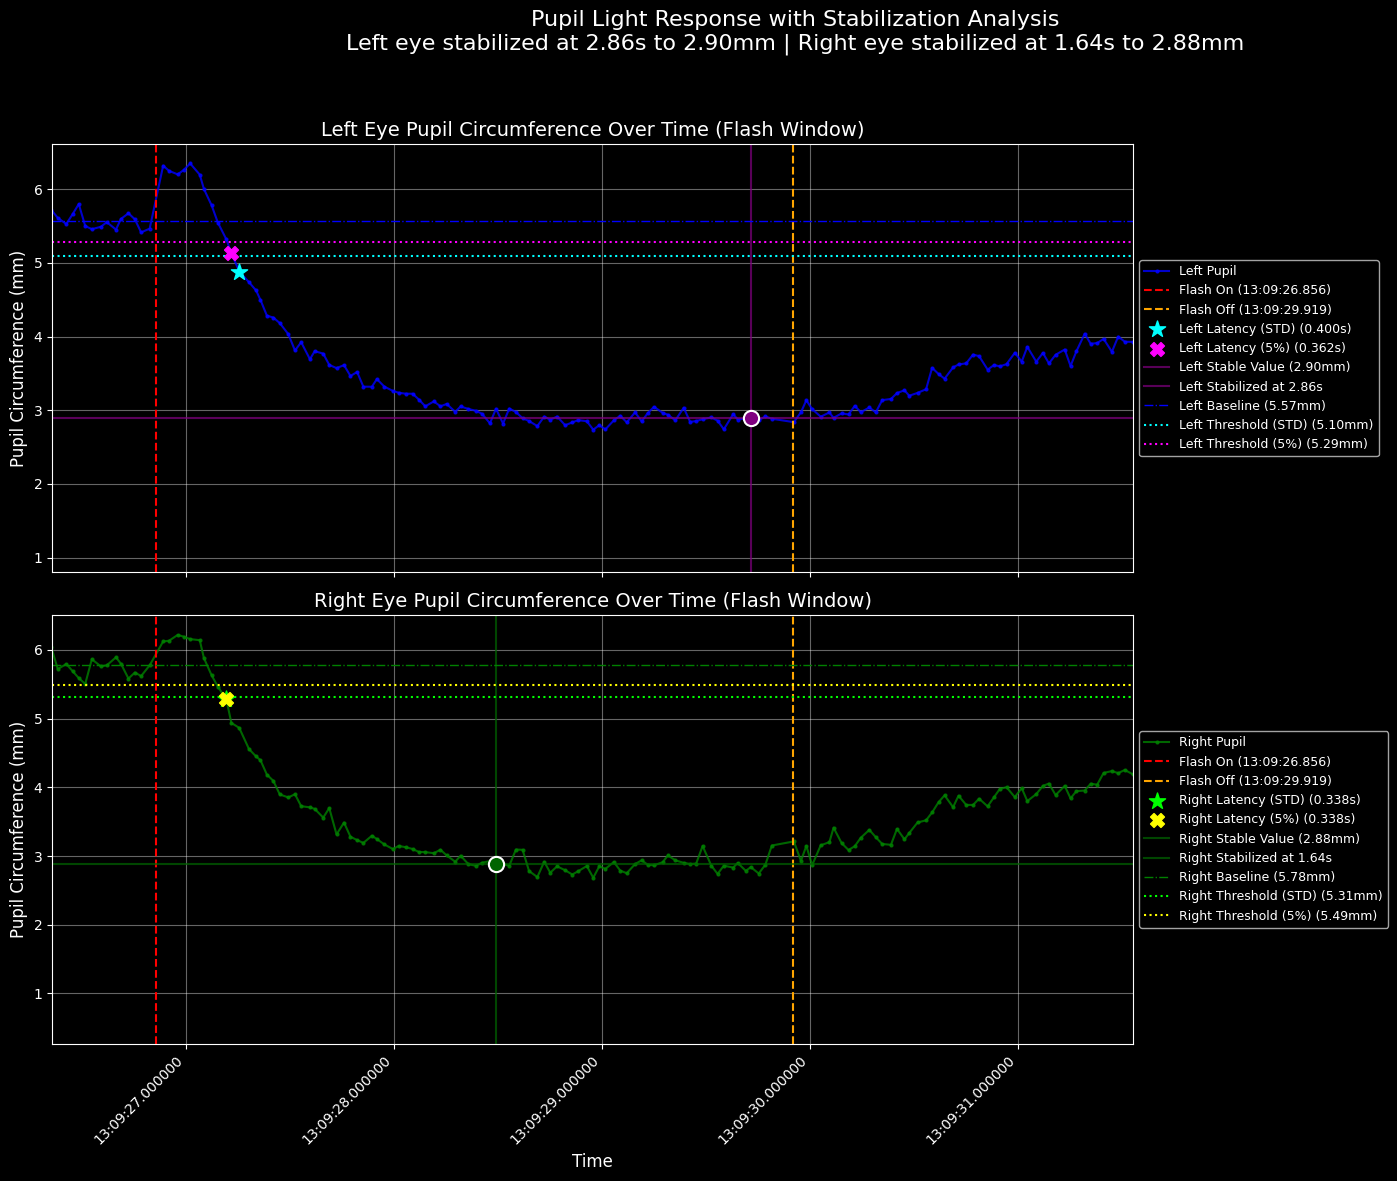

In [64]:
# Modified plotting code for visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Define the time window for the plot
plot_start_time = flash_on_timestamp - pd.Timedelta(seconds=0.5)  # Start 0.5 seconds before flash
plot_end_time = results['timestamp'].iloc[-1]

# Get stabilization info using the find_stabilization function
stabilization_info = find_stabilization(results, flash_on_timestamp, 
                                       response_left_idx=response_left_idx, 
                                       response_right_idx=response_right_idx, 
                                       window_size=10, std_threshold=0.10)

# Calculate stabilization timestamps
if stabilization_info['left']['time'] is not None:
    # Get timestamps for both stability onset and closest match point
    stable_timestamp_left = flash_on_timestamp + pd.Timedelta(seconds=stabilization_info['left']['time'])
    stable_value_left = stabilization_info['left']['value']
    
    closest_match_timestamp_left = flash_on_timestamp + pd.Timedelta(seconds=stabilization_info['left']['closest_match_time'])
    closest_match_value_left = stabilization_info['left']['closest_match_value']
else:
    stable_timestamp_left = None
    stable_value_left = None
    closest_match_timestamp_left = None
    closest_match_value_left = None
    
if stabilization_info['right']['time'] is not None:
    # Get timestamps for both stability onset and closest match point
    stable_timestamp_right = flash_on_timestamp + pd.Timedelta(seconds=stabilization_info['right']['time'])
    stable_value_right = stabilization_info['right']['value']
    
    closest_match_timestamp_right = flash_on_timestamp + pd.Timedelta(seconds=stabilization_info['right']['closest_match_time'])
    closest_match_value_right = stabilization_info['right']['closest_match_value']
else:
    stable_timestamp_right = None
    stable_value_right = None
    closest_match_timestamp_right = None
    closest_match_value_right = None

# Create a figure with two subplots (one for each eye)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)  # Share x-axis

# --- Left Eye Plot (ax1) ---
ax1.plot(results['timestamp'], results['circumference_mm_pupil_left'],
         label='Left Pupil', color='blue', linewidth=1.5, alpha=0.8, marker='.', markersize=4)

# Vertical Lines (Flash & Latency)
ax1.axvline(x=flash_on_timestamp, color='red', linestyle='--', linewidth=1.5,
            label=f'Flash On ({flash_on_timestamp.strftime("%H:%M:%S.%f")[:-3]})')
ax1.axvline(x=flash_off_timestamp, color='orange', linestyle='--', linewidth=1.5,
            label=f'Flash Off ({flash_off_timestamp.strftime("%H:%M:%S.%f")[:-3]})')

# Latency Points
latency_timestamp_left_std = results.loc[response_std_left_idx, 'timestamp']
latency_value_left_std = results.loc[response_std_left_idx, 'circumference_mm_pupil_left']
latency_left_std = (latency_timestamp_left_std - flash_on_timestamp).total_seconds()
ax1.scatter([latency_timestamp_left_std], [latency_value_left_std], color='cyan', s=150, marker='*', zorder=5,
            label=f'Left Latency (STD) ({latency_left_std:.3f}s)')

latency_timestamp_left_pct = results.loc[response_left_idx, 'timestamp']
latency_value_left_pct = results.loc[response_left_idx, 'circumference_mm_pupil_left']
latency_left_pct = (latency_timestamp_left_pct - flash_on_timestamp).total_seconds()
ax1.scatter([latency_timestamp_left_pct], [latency_value_left_pct], color='magenta', s=100, marker='X', zorder=5,
            label=f'Left Latency ({threshold_pct}%) ({latency_left_pct:.3f}s)')

# Add stabilization indicators for left eye
if stable_timestamp_left is not None:
    # Add horizontal line for stabilized value (mean after stabilization)
    ax1.axhline(y=stable_value_left, color='purple', linestyle='-', linewidth=1.5, alpha=0.7,
                label=f'Left Stable Value ({stable_value_left:.2f}mm)')
    
    # Add vertical line at the point closest to the mean stable value
    ax1.axvline(x=closest_match_timestamp_left, color='purple', linestyle='-', linewidth=1.5, alpha=0.7,
                label=f'Left Stabilized at {stabilization_info["left"]["closest_match_time"]:.2f}s')
    
    # Add marker at the closest match point
    ax1.scatter([closest_match_timestamp_left], [closest_match_value_left], color='purple', s=120, marker='o', 
                edgecolors='white', linewidths=1.5, zorder=6)

# Horizontal Lines (Baseline & Thresholds)
ax1.axhline(y=baseline_left, color='blue', linestyle='-.', linewidth=1,
            label=f'Left Baseline ({baseline_left:.2f}mm)')
ax1.axhline(y=threshold_std_left, color='cyan', linestyle=':', linewidth=1.5,
            label=f'Left Threshold (STD) ({threshold_std_left:.2f}mm)')
ax1.axhline(y=threshold_left, color='magenta', linestyle=':', linewidth=1.5,
            label=f'Left Threshold ({threshold_pct}%) ({threshold_left:.2f}mm)')

# Customization
ax1.set_ylabel('Pupil Circumference (mm)', fontsize=12)
ax1.set_title('Left Eye Pupil Circumference Over Time (Flash Window)', fontsize=14)
ax1.grid(True, alpha=0.4)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
ax1.set_xlim(plot_start_time, plot_end_time)


# --- Right Eye Plot (ax2) ---
ax2.plot(results['timestamp'], results['circumference_mm_pupil_right'],
         label='Right Pupil', color='green', linewidth=1.5, alpha=0.8, marker='.', markersize=4)

# Vertical Lines (Flash & Latency)
ax2.axvline(x=flash_on_timestamp, color='red', linestyle='--', linewidth=1.5,
            label=f'Flash On ({flash_on_timestamp.strftime("%H:%M:%S.%f")[:-3]})')
ax2.axvline(x=flash_off_timestamp, color='orange', linestyle='--', linewidth=1.5,
            label=f'Flash Off ({flash_off_timestamp.strftime("%H:%M:%S.%f")[:-3]})')

# Latency Points
latency_timestamp_right_std = results.loc[response_std_right_idx, 'timestamp']
latency_value_right_std = results.loc[response_std_right_idx, 'circumference_mm_pupil_right']
latency_right_std = (latency_timestamp_right_std - flash_on_timestamp).total_seconds()
ax2.scatter([latency_timestamp_right_std], [latency_value_right_std], color='lime', s=150, marker='*', zorder=5,
            label=f'Right Latency (STD) ({latency_right_std:.3f}s)')

latency_timestamp_right_pct = results.loc[response_right_idx, 'timestamp']
latency_value_right_pct = results.loc[response_right_idx, 'circumference_mm_pupil_right']
latency_right_pct = (latency_timestamp_right_pct - flash_on_timestamp).total_seconds()
ax2.scatter([latency_timestamp_right_pct], [latency_value_right_pct], color='yellow', s=100, marker='X', zorder=5,
            label=f'Right Latency ({threshold_pct}%) ({latency_right_pct:.3f}s)')

# Add stabilization indicators for right eye
if stable_timestamp_right is not None:
    # Add horizontal line for stabilized value (mean)
    ax2.axhline(y=stable_value_right, color='darkgreen', linestyle='-', linewidth=1.5, alpha=0.7,
                label=f'Right Stable Value ({stable_value_right:.2f}mm)')
    
    # Add vertical line at the point closest to the mean stable value
    ax2.axvline(x=closest_match_timestamp_right, color='darkgreen', linestyle='-', linewidth=1.5, alpha=0.7,
                label=f'Right Stabilized at {stabilization_info["right"]["closest_match_time"]:.2f}s')
    
    # Add marker at the closest match point
    ax2.scatter([closest_match_timestamp_right], [closest_match_value_right], color='darkgreen', s=120, marker='o', 
                edgecolors='white', linewidths=1.5, zorder=6)

# Horizontal Lines (Baseline & Thresholds)
ax2.axhline(y=baseline_right, color='green', linestyle='-.', linewidth=1,
            label=f'Right Baseline ({baseline_right:.2f}mm)')
ax2.axhline(y=threshold_std_right, color='lime', linestyle=':', linewidth=1.5,
            label=f'Right Threshold (STD) ({threshold_std_right:.2f}mm)')
ax2.axhline(y=threshold_right, color='yellow', linestyle=':', linewidth=1.5,
            label=f'Right Threshold ({threshold_pct}%) ({threshold_right:.2f}mm)')

# Customization
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('Pupil Circumference (mm)', fontsize=12)
ax2.set_title('Right Eye Pupil Circumference Over Time (Flash Window)', fontsize=14)
ax2.grid(True, alpha=0.4)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
ax2.set_xlim(plot_start_time, plot_end_time)

# Format x-axis for both plots
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S.%f'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add suptitle with stabilization summary
left_match_info = f"Left eye stabilized at {stabilization_info['left']['closest_match_time']:.2f}s to {stable_value_left:.2f}mm" if stabilization_info['left']['time'] is not None else "Left eye stabilization not found"
right_match_info = f"Right eye stabilized at {stabilization_info['right']['closest_match_time']:.2f}s to {stable_value_right:.2f}mm" if stabilization_info['right']['time'] is not None else "Right eye stabilization not found"

plt.suptitle(
    f"Pupil Light Response with Stabilization Analysis\n"
    f"{left_match_info} | {right_match_info}",
    fontsize=16
)

# Adjust layout to prevent labels overlapping
plt.tight_layout(rect=[0, 0, 0.88, 0.95])  # Leave space on the right for legends and top for title

# Show the plot
plt.show()

In [66]:
def calculate_total_constriction(baseline_value, stabilized_value):
    """
    Calculate the total pupil constriction amplitude.
    
    Args:
        baseline_value: The baseline pupil circumference (mm) before flash
        stabilized_value: The stabilized pupil circumference (mm) after constriction
    
    Returns:
        dict: Constriction metrics including:
            - absolute_change: The absolute change in mm
            - percent_change: The percentage change relative to baseline
    """
    # Calculate the absolute change in circumference
    absolute_change = baseline_value - stabilized_value
    
    # Calculate the percentage change relative to baseline
    percent_change = (absolute_change / baseline_value) * 100 if baseline_value != 0 else None
    
    return {
        'absolute_change': absolute_change,  # mm
        'percent_change': percent_change     # %
    }
    
# Calculate constriction metrics for both eyes
constriction_left = calculate_total_constriction(baseline_left, stable_value_left)
constriction_right = calculate_total_constriction(baseline_right, stable_value_right)
constriction_left, constriction_right

({'absolute_change': np.float64(2.6659127386038404),
  'percent_change': np.float64(47.8932975391239)},
 {'absolute_change': np.float64(2.895330774349404),
  'percent_change': np.float64(50.120586791652414)})

In [72]:
def calculate_constriction_velocity(results_df, response_idx, stabilization_timestamp, 
                                    baseline_value, stabilized_value, eye_side='left'):
    """
    Calculate the velocity of pupil constriction.
    
    Args:
        results_df: DataFrame containing pupil measurements
        response_idx: Index when pupil response begins
        stabilization_timestamp: Timestamp when pupil stabilized
        baseline_value: Baseline pupil circumference (mm)
        stabilized_value: Stabilized pupil circumference (mm)
        eye_side: 'left' or 'right' to specify which eye
    
    Returns:
        dict: Velocity metrics including:
            - per_frame_velocities: List of velocities for each frame
            - average_velocity: Average constriction velocity in mm/s
            - peak_velocity: Maximum constriction velocity in mm/s
            - time_to_peak_velocity: Time from response onset to peak velocity
    """
    # Get data from response onset to stabilization
    constriction_data = results_df.loc[
        (results_df.index >= response_idx) &
        (results_df['timestamp'] <= stabilization_timestamp)
    ].copy()
    
    if len(constriction_data) <= 1:
        return {
            'per_frame_velocities': [],
            'average_velocity': None,
            'peak_velocity': None,
            'time_to_peak_velocity': None
        }
    
    # Calculate the time elapsed for each frame from response onset
    response_timestamp = results_df.loc[response_idx, 'timestamp']
    constriction_data['elapsed_seconds'] = (constriction_data['timestamp'] - response_timestamp).dt.total_seconds()
    
    # Calculate derivatives (velocity = change in circumference / change in time)
    circumference_col = f'circumference_mm_pupil_{eye_side}'
    constriction_data['velocity'] = constriction_data[circumference_col].diff() / constriction_data['elapsed_seconds'].diff()
    
    # Keep negative values for constriction (getting smaller)
    # We'll find the minimum velocity (most negative) for peak constriction
    
    # Remove potential NaN values (first row after diff)
    valid_data = constriction_data.dropna(subset=['velocity'])
    
    if len(valid_data) == 0:
        return {
            'per_frame_velocities': [],
            'average_velocity': None,
            'peak_velocity': None,
            'time_to_peak_velocity': None
        }
    
    # Get list of velocities for each frame
    per_frame_velocities = valid_data['velocity'].tolist()
    
    # Calculate average velocity (total change / total time)
    total_time = (stabilization_timestamp - response_timestamp).total_seconds()
    total_change = baseline_value - stabilized_value  # This will be positive for constriction
    average_velocity = -total_change / total_time if total_time > 0 else None  # Negative for constriction
    
    # Find peak velocity (minimum value = maximum constriction speed)
    peak_velocity_idx = valid_data['velocity'].idxmin()
    peak_velocity = valid_data.loc[peak_velocity_idx, 'velocity']
    
    # Calculate time to peak velocity
    time_to_peak = valid_data.loc[peak_velocity_idx, 'elapsed_seconds']
    
    return {
        'per_frame_velocities': per_frame_velocities,
        'average_velocity': average_velocity,      # mm/s (negative for constriction)
        'peak_velocity': peak_velocity,            # mm/s (negative for constriction)
        'time_to_peak_velocity': time_to_peak      # seconds
    }
    
# Calculate constriction velocity for both eyes
constriction_velocity_left = calculate_constriction_velocity(
    results, response_left_idx, stable_timestamp_left, baseline_left, stable_value_left, eye_side='left'
)
constriction_velocity_right = calculate_constriction_velocity(
    results, response_right_idx, stable_timestamp_right, baseline_right, stable_value_right, eye_side='right'
)
constriction_velocity_left, constriction_velocity_right

({'per_frame_velocities': [-6.622668138908304,
   -3.100431242247428,
   -3.285481556913309,
   -6.087041533823694,
   -6.9062779985271945,
   -0.8253525562485934,
   -2.4310757506298266,
   -3.6489565610632995,
   -6.938379177549184,
   3.7232745963307763,
   -5.475188452924847,
   4.718337095289745,
   -0.8038308759265173,
   -5.2806090995885935,
   -1.2390084858231951,
   1.1176230878234819,
   -4.7572410612564395,
   1.7155119950056488,
   -6.65562902732014,
   -0.02521470010081574,
   4.329378247256004,
   -2.8369340387956994,
   -1.4193627939863307,
   -0.9031031442794847,
   -0.37022739401066235,
   -0.018830417203525903,
   -2.609593314885096,
   -2.9769697447777776,
   1.6170594767822244,
   -2.0731792288483497,
   1.0570007458067308],
  'average_velocity': np.float64(-2.573274844212201),
  'peak_velocity': np.float64(-6.938379177549184),
  'time_to_peak_velocity': np.float64(0.306)},
 {'per_frame_velocities': [-14.287317582788745,
   -1.9027579220918363,
   -6.579445490187258

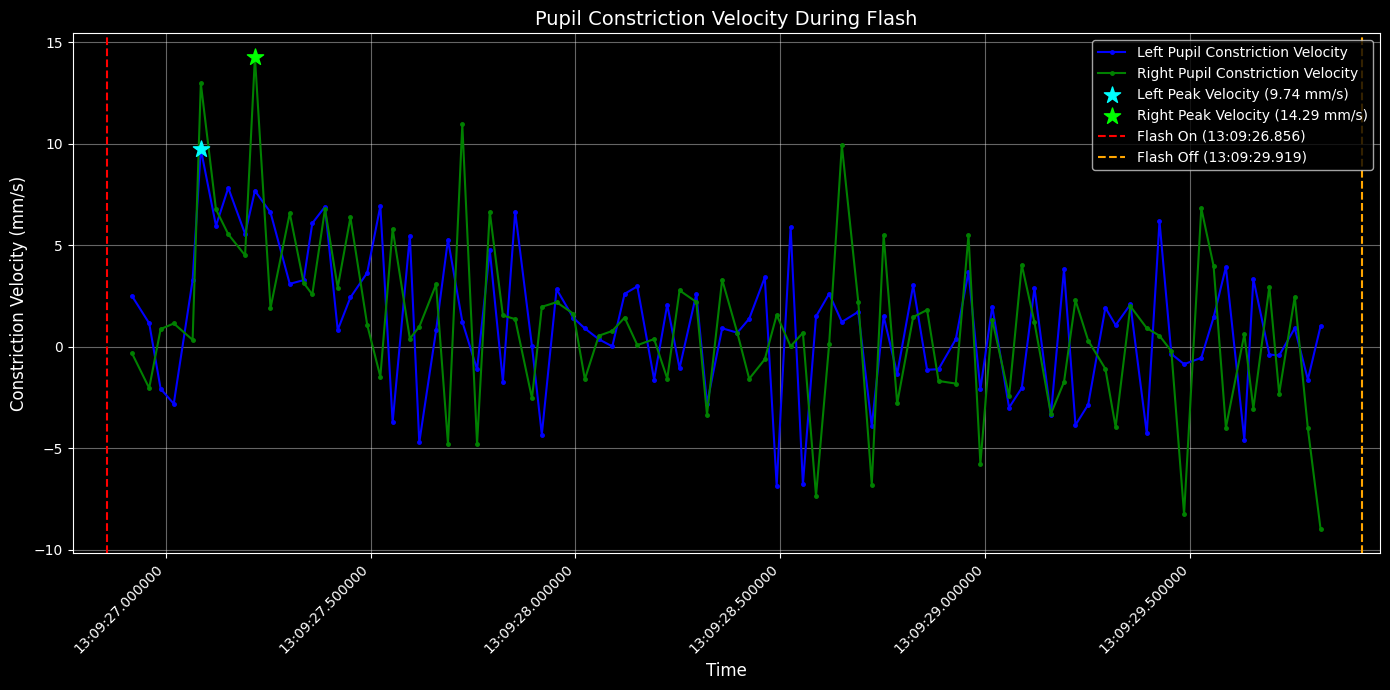

Peak Left Constriction Velocity: 9.74 mm/s at 2024-08-29 13:09:27.086000
Peak Right Constriction Velocity: 14.29 mm/s at 2024-08-29 13:09:27.218000


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filter data for the duration of the flash
flash_data = results[(results['timestamp'] >= flash_on_timestamp) &
                     (results['timestamp'] <= flash_off_timestamp)].copy()

# Calculate time difference between consecutive frames in seconds
flash_data['time_diff'] = flash_data['timestamp'].diff().dt.total_seconds()

# Calculate change in pupil circumference
flash_data['circum_diff_left'] = flash_data['circumference_mm_pupil_left'].diff()
flash_data['circum_diff_right'] = flash_data['circumference_mm_pupil_right'].diff()

# Calculate pupil velocity (change in circumference / change in time)
# Negative values indicate constriction (pupil getting smaller)
# Avoid division by zero or NaN for the first row
flash_data['velocity_left'] = flash_data['circum_diff_left'] / flash_data['time_diff']
flash_data['velocity_right'] = flash_data['circum_diff_right'] / flash_data['time_diff']

# Find peak constriction velocities (most negative velocity) and their timestamps
peak_constriction_velocity_left = flash_data['velocity_left'].min()
peak_constriction_velocity_right = flash_data['velocity_right'].min()

# Handle cases where min velocity might be NaN (e.g., only one data point)
if pd.notna(peak_constriction_velocity_left):
    peak_constriction_time_left = flash_data.loc[flash_data['velocity_left'].idxmin(), 'timestamp']
    peak_constriction_value_left = peak_constriction_velocity_left
else:
    peak_constriction_time_left, peak_constriction_value_left = None, None

if pd.notna(peak_constriction_velocity_right):
    peak_constriction_time_right = flash_data.loc[flash_data['velocity_right'].idxmin(), 'timestamp']
    peak_constriction_value_right = peak_constriction_velocity_right
else:
    peak_constriction_time_right, peak_constriction_value_right = None, None


# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot pupil velocities (skip the first NaN value)
ax.plot(flash_data['timestamp'].iloc[1:], flash_data['velocity_left'].iloc[1:],
        label='Left Pupil Velocity', color='blue', marker='.', linestyle='-', markersize=5)
ax.plot(flash_data['timestamp'].iloc[1:], flash_data['velocity_right'].iloc[1:],
        label='Right Pupil Velocity', color='green', marker='.', linestyle='-', markersize=5)

# Mark peak constriction velocity points (minimum velocity)
if peak_constriction_time_left:
    ax.scatter([peak_constriction_time_left], [peak_constriction_value_left], color='cyan', s=150, marker='*', zorder=5,
               label=f'Left Peak Constriction ({peak_constriction_value_left:.2f} mm/s)')
if peak_constriction_time_right:
    ax.scatter([peak_constriction_time_right], [peak_constriction_value_right], color='lime', s=150, marker='*', zorder=5,
               label=f'Right Peak Constriction ({peak_constriction_value_right:.2f} mm/s)')

# Add a horizontal line at y=0 to indicate change direction
ax.axhline(y=0, color='grey', linestyle=':', linewidth=1, label='Zero Velocity')

# Add vertical lines for flash duration
ax.axvline(x=flash_on_timestamp, color='red', linestyle='--', linewidth=1.5,
           label=f'Flash On ({flash_on_timestamp.strftime("%H:%M:%S.%f")[:-3]})')
ax.axvline(x=flash_off_timestamp, color='orange', linestyle='--', linewidth=1.5,
           label=f'Flash Off ({flash_off_timestamp.strftime("%H:%M:%S.%f")[:-3]})')

# Add labels and title
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Pupil Velocity (mm/s)', fontsize=12)
ax.set_title('Pupil Velocity During Flash (Negative = Constriction)', fontsize=14)
ax.grid(True, alpha=0.4)
ax.legend(loc='lower left') # Adjusted legend location

# Format x-axis to show time clearly
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S.%f'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Print peak constriction velocity info
print(f"Peak Left Constriction Velocity (Min Velocity): {peak_constriction_value_left:.2f} mm/s at {peak_constriction_time_left}")
print(f"Peak Right Constriction Velocity (Min Velocity): {peak_constriction_value_right:.2f} mm/s at {peak_constriction_time_right}")


In [ ]:
# PROTOYPE - GOTTA VALIDATE THESE RESULTS HERE
    
def calculate_constriction_metrics(results_df, flash_on_timestamp, flash_off_timestamp=None):
    """
    Calculate metrics related to the speed of pupil constriction.
    
    Args:
        results_df: DataFrame with pupil measurements
        flash_on_timestamp: When flash turned on
        flash_off_timestamp: When flash turned off (optional)
    
    Returns:
        Dictionary with various constriction speed metrics
    """
    # Get pre-flash baseline (average of last 10 frames before flash)
    pre_flash = results_df[results_df['timestamp'] < flash_on_timestamp].tail(10)
    baseline_left = pre_flash['circumference_mm_pupil_left'].mean()
    baseline_right = pre_flash['circumference_mm_pupil_right'].mean()
    
    # Get post-flash data
    if flash_off_timestamp:
        post_flash = results_df[(results_df['timestamp'] >= flash_on_timestamp) & 
                               (results_df['timestamp'] <= flash_off_timestamp)].copy()
    else:
        post_flash = results_df[results_df['timestamp'] >= flash_on_timestamp].copy()
    
    # Calculate time since flash onset
    post_flash['seconds_since_flash'] = (post_flash['timestamp'] - flash_on_timestamp).dt.total_seconds()
    
    # Calculate minimum value during flash period (maximum constriction)
    min_left = post_flash['circumference_mm_pupil_left'].min()
    min_right = post_flash['circumference_mm_pupil_right'].min()
    
    # Total constriction amplitude
    amplitude_left = baseline_left - min_left
    amplitude_right = baseline_right - min_right
    
    # Calculate derivatives (mm/second)
    post_flash['derivative_left'] = post_flash['circumference_mm_pupil_left'].diff() / \
                                   post_flash['seconds_since_flash'].diff()
    post_flash['derivative_right'] = post_flash['circumference_mm_pupil_right'].diff() / \
                                    post_flash['seconds_since_flash'].diff()
    
    # Maximum constriction velocity (minimum derivative, as constriction is negative change)
    max_velocity_left = post_flash['derivative_left'].min() * -1  # Convert to positive
    max_velocity_right = post_flash['derivative_right'].min() * -1  # Convert to positive
    
    # When does maximum velocity occur?
    max_vel_idx_left = post_flash['derivative_left'].idxmin()
    max_vel_idx_right = post_flash['derivative_right'].idxmin()
    max_vel_time_left = post_flash.loc[max_vel_idx_left, 'seconds_since_flash']
    max_vel_time_right = post_flash.loc[max_vel_idx_right, 'seconds_since_flash']
    
    # Time to reach 50% constriction
    half_constriction_left = baseline_left - (amplitude_left * 0.5)
    half_constriction_right = baseline_right - (amplitude_right * 0.5)
    
    try:
        time_to_half_left = post_flash[post_flash['circumference_mm_pupil_left'] <= half_constriction_left].iloc[0]['seconds_since_flash']
    except IndexError:
        time_to_half_left = None
        
    try:
        time_to_half_right = post_flash[post_flash['circumference_mm_pupil_right'] <= half_constriction_right].iloc[0]['seconds_since_flash']
    except IndexError:
        time_to_half_right = None
    
    # Average constriction speed (mm/s) - from onset to 90% of constriction
    ninety_pct_left = baseline_left - (amplitude_left * 0.9)
    ninety_pct_right = baseline_right - (amplitude_right * 0.9)
    
    try:
        time_to_90pct_left = post_flash[post_flash['circumference_mm_pupil_left'] <= ninety_pct_left].iloc[0]['seconds_since_flash'] 
        avg_speed_left = (baseline_left - ninety_pct_left) / time_to_90pct_left if time_to_90pct_left > 0 else None
    except IndexError:
        time_to_90pct_left = None
        avg_speed_left = None
        
    try:
        time_to_90pct_right = post_flash[post_flash['circumference_mm_pupil_right'] <= ninety_pct_right].iloc[0]['seconds_since_flash']
        avg_speed_right = (baseline_right - ninety_pct_right) / time_to_90pct_right if time_to_90pct_right > 0 else None
    except IndexError:
        time_to_90pct_right = None
        avg_speed_right = None
    
    return {
        'left': {
            'baseline': baseline_left,
            'min_value': min_left,
            'amplitude': amplitude_left,
            'max_velocity': max_velocity_left,
            'max_velocity_time': max_vel_time_left,
            'time_to_half_constriction': time_to_half_left,
            'time_to_90pct_constriction': time_to_90pct_left,
            'average_constriction_speed': avg_speed_left
        },
        'right': {
            'baseline': baseline_right,
            'min_value': min_right,
            'amplitude': amplitude_right,
            'max_velocity': max_velocity_right,
            'max_velocity_time': max_vel_time_right,
            'time_to_half_constriction': time_to_half_right,
            'time_to_90pct_constriction': time_to_90pct_right,
            'average_constriction_speed': avg_speed_right
        }
    }
    
from scipy.optimize import curve_fit

def exponential_decay(t, a, b, c, tau):
    """Exponential decay function: a + b * exp(-t/tau) + c*t"""
    return a + b * np.exp(-t/tau) + c*t

def fit_exponential_to_pupil_response(results_df, flash_on_timestamp, flash_off_timestamp):
    """Fit exponential decay to pupil constriction phase"""
    # Get data during constriction phase
    constriction_data = results_df[(results_df['timestamp'] >= flash_on_timestamp) & 
                                  (results_df['timestamp'] <= flash_off_timestamp)].copy()
    
    # Calculate time in seconds from flash onset
    constriction_data['time'] = (constriction_data['timestamp'] - flash_on_timestamp).dt.total_seconds()
    
    # Perform curve fitting for left eye
    try:
        t = constriction_data['time'].values
        y_left = constriction_data['circumference_mm_pupil_left'].values
        y_right = constriction_data['circumference_mm_pupil_right'].values
        
        # Initial parameter guesses [final_value, amplitude, linear_term, time_constant]
        p0_left = [3.0, 3.0, 0.0, 0.5]  
        p0_right = [3.0, 3.0, 0.0, 0.5]
        
        # Fit the curve
        popt_left, _ = curve_fit(exponential_decay, t, y_left, p0=p0_left)
        popt_right, _ = curve_fit(exponential_decay, t, y_right, p0=p0_right)
        
        # Extract parameters
        a_left, b_left, c_left, tau_left = popt_left
        a_right, b_right, c_right, tau_right = popt_right
        
        return {
            'left': {
                'asymptotic_value': a_left, 
                'amplitude': b_left,
                'linear_term': c_left,
                'time_constant': tau_left,  # Key measure of constriction speed
                'params': popt_left,
            },
            'right': {
                'asymptotic_value': a_right, 
                'amplitude': b_right,
                'linear_term': c_right,
                'time_constant': tau_right,  # Key measure of constriction speed
                'params': popt_right,
            }
        }
    except Exception as e:
        return {'error': str(e)}
    
    
def visualize_pupil_response_metrics(results_df, flash_on_timestamp, flash_off_timestamp,
                                     latency, stabilization, constriction_metrics, fit_params=None):
    """Create a comprehensive visualization of pupil response with metrics"""
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot pupil circumference data
    ax.plot(results_df['timestamp'], results_df['circumference_mm_pupil_left'], 
            label='Left Pupil', color='blue', linewidth=2)
    ax.plot(results_df['timestamp'], results_df['circumference_mm_pupil_right'], 
            label='Right Pupil', color='green', linewidth=2)
    
    # Flash on/off lines
    ax.axvline(x=flash_on_timestamp, color='red', linestyle='--', linewidth=1.5, 
              label='Flash On')
    ax.axvline(x=flash_off_timestamp, color='orange', linestyle='--', linewidth=1.5, 
              label='Flash Off')
    
    # Mark latency points
    latency_timestamp_left = flash_on_timestamp + pd.Timedelta(seconds=latency[0])
    latency_timestamp_right = flash_on_timestamp + pd.Timedelta(seconds=latency[1])
    
    left_val_at_latency = results_df[results_df['timestamp'] >= latency_timestamp_left].iloc[0]['circumference_mm_pupil_left']
    right_val_at_latency = results_df[results_df['timestamp'] >= latency_timestamp_right].iloc[0]['circumference_mm_pupil_right']
    
    ax.scatter([latency_timestamp_left], [left_val_at_latency], color='blue', s=100, marker='*',
              label=f'Left Latency ({latency[0]:.2f}s)')
    ax.scatter([latency_timestamp_right], [right_val_at_latency], color='green', s=100, marker='*',
              label=f'Right Latency ({latency[1]:.2f}s)')
    
    # Mark stabilization points
    if stabilization['left']['time'] is not None:
        stable_timestamp_left = flash_on_timestamp + pd.Timedelta(seconds=stabilization['left']['time'])
        ax.scatter([stable_timestamp_left], [stabilization['left']['value']], color='blue', s=100, marker='o',
                  label=f'Left Stabilized ({stabilization["left"]["time"]:.2f}s)')
        
    if stabilization['right']['time'] is not None:
        stable_timestamp_right = flash_on_timestamp + pd.Timedelta(seconds=stabilization['right']['time'])
        ax.scatter([stable_timestamp_right], [stabilization['right']['value']], color='green', s=100, marker='o',
                  label=f'Right Stabilized ({stabilization["right"]["time"]:.2f}s)')
    
    # Annotate constriction speeds
    left_speed = constriction_metrics['left']['average_constriction_speed']
    right_speed = constriction_metrics['right']['average_constriction_speed']
    
    if left_speed is not None:
        ax.annotate(f"Left Speed: {left_speed:.2f} mm/s", 
                   xy=(0.02, 0.95), xycoords='axes fraction', fontsize=10,
                   bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", alpha=0.7))
    
    if right_speed is not None:
        ax.annotate(f"Right Speed: {right_speed:.2f} mm/s", 
                   xy=(0.02, 0.90), xycoords='axes fraction', fontsize=10,
                   bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", alpha=0.7))
    
    # Add exponential fit if provided
    if fit_params:
        # Create a time range from flash onset to flash offset for smooth curve
        t_fit = np.linspace(0, (flash_off_timestamp - flash_on_timestamp).total_seconds(), 100)
        timestamps_fit = [flash_on_timestamp + pd.Timedelta(seconds=t) for t in t_fit]
        
        # Generate fitted curves
        y_fit_left = exponential_decay(t_fit, *fit_params['left']['params'])
        y_fit_right = exponential_decay(t_fit, *fit_params['right']['params'])
        
        # Plot fitted curves
        ax.plot(timestamps_fit, y_fit_left, 'b--', linewidth=1.5, 
               label=f'Left Fit (τ={fit_params["left"]["time_constant"]:.2f}s)')
        ax.plot(timestamps_fit, y_fit_right, 'g--', linewidth=1.5, 
               label=f'Right Fit (τ={fit_params["right"]["time_constant"]:.2f}s)')
    
    # Formatting
    ax.set_xlabel('Time')
    ax.set_ylabel('Pupil Circumference (mm)')
    ax.set_title('Pupil Light Response with Metrics', fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=9)
    
    # Format x-axis to show time better
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    
    return fig

# Extract the metrics
latency_left, latency_right = calculate_latency(results, flash_on_timestamp, threshold_pct=5)
stabilization = find_stabilization(results, flash_on_timestamp, window_size=10)
constriction_metrics = calculate_constriction_metrics(results, flash_on_timestamp, flash_off_timestamp)
fit_results = fit_exponential_to_pupil_response(results, flash_on_timestamp, flash_off_timestamp)

# Print a summary
print(f"Time latency (seconds): Left={latency_left:.3f}, Right={latency_right:.3f}")
print(f"\nStabilized values:")
print(f"Left eye: {stabilization['left']['value']:.2f}mm at {stabilization['left']['time']:.2f}s after flash")
print(f"Right eye: {stabilization['right']['value']:.2f}mm at {stabilization['right']['time']:.2f}s after flash")
print(f"\nConstriction speed:")
print(f"Left eye: {constriction_metrics['left']['average_constriction_speed']:.2f}mm/s")
print(f"Right eye: {constriction_metrics['right']['average_constriction_speed']:.2f}mm/s")
print(f"\nExponential fit time constants:")
print(f"Left eye: {fit_results['left']['time_constant']:.3f}s")
print(f"Right eye: {fit_results['right']['time_constant']:.3f}s")

In [ ]:
# --- Enhanced Animation with Complete Eye Elements for Both Eyes ---
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import numpy as np
from collections import deque

def evaluate_plot_limits(data, padding_factor=0.2, min_padding=10):
    """Calculate optimal plot limits based on sclera fissure points with padding factor."""
    
    # Extract all x and y coordinates from both left and right sclera fissure points
    all_x = []
    all_y = []
    
    # Iterate through all rows and collect all sclera fissure points (left and right)
    for points in data['points_sclera_left']:
        for point in points:
            all_x.append(point[0])
            all_y.append(point[1])
    
    for points in data['points_sclera_right']:
        for point in points:
            all_x.append(point[0])
            all_y.append(point[1])
    
    # Calculate padding
    x_padding = (max(all_x) - min(all_x)) * padding_factor if max(all_x) != min(all_x) else min_padding
    y_padding = (max(all_y) - min(all_y)) * padding_factor if max(all_y) != min(all_y) else min_padding
    
    # Calculate limits
    x_min = min(all_x) - x_padding
    x_max = max(all_x) + x_padding
    y_min = min(all_y) - y_padding
    y_max = max(all_y) + y_padding
    
    return x_min, x_max, y_min, y_max

def initialize_figure_and_axes_plot_elements(x_min, x_max, y_min, y_max, trail_length=20):
    """Initialize the figure, axes, and all plot elements with dark style."""
    # Set dark background style
    plt.style.use('dark_background')
    plt.subplots_adjust(bottom=0.2)  # Increase bottom margin
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Configure axes
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("X Coordinate", color='white')
    ax.set_ylabel("Y Coordinate", color='white')
    ax.set_title("Complete Eye Tracking Visualization (Both Eyes)", color='white')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    ax.invert_yaxis()  # Invert y-axis for correct orientation
    
    # Set tick colors to white
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    
    # Initialize plot elements with proper z-ordering (higher zorder = appears on top)
    
    # 1. Circle polygons (ideal circular shapes) - dashed lines
    circle_iris_left, = ax.plot([], [], 'g', alpha=0.5, linewidth=1.0, 
                                 label='Left Ideal Iris', zorder=1)
    circle_pupil_left, = ax.plot([], [], 'c', alpha=0.5, linewidth=1.0, 
                                  label='Left Ideal Pupil', zorder=2)
    circle_iris_right, = ax.plot([], [], 'g', alpha=0.5, linewidth=1.0, 
                                  label='Right Ideal Iris', zorder=1)
    circle_pupil_right, = ax.plot([], [], 'c', alpha=0.5, linewidth=1.0, 
                                   label='Right Ideal Pupil', zorder=2)
    
    # 2. sclera elements
    sclera_polygon_left, = ax.plot([], [], 'y-', alpha=0.7, linewidth=1.5, 
                                      label='Left Sclera', zorder=3)
    sclera_scatter_left = ax.scatter([], [], facecolors='yellow', alpha=0.6, s=10, 
                                       label='Left Sclera Points', zorder=4)
    sclera_polygon_right, = ax.plot([], [], 'y-', alpha=0.7, linewidth=1.5, 
                                       label='Right Sclera', zorder=3)
    sclera_scatter_right = ax.scatter([], [], facecolors='yellow', alpha=0.6, s=10, 
                                        label='Right Sclera Points', zorder=4)
    
    # 3. Iris elements
    iris_polygon_left, = ax.plot([], [], color='g', linestyle=':', alpha=0.7, linewidth=1.5, 
                                label='Left Iris', zorder=5)
    iris_scatter_left = ax.scatter([], [], facecolors='green', alpha=0.6, s=10, 
                                  label='Left Iris Points', zorder=6)
    iris_polygon_right, = ax.plot([], [], color='g', linestyle=':', alpha=0.7, linewidth=1.5, 
                                 label='Right Iris', zorder=5)
    iris_scatter_right = ax.scatter([], [], facecolors='green', alpha=0.6, s=10, 
                                   label='Right Iris Points', zorder=6)
    
    # 4. Pupil elements
    pupil_polygon_left, = ax.plot([], [], color='c', linestyle=':', alpha=0.7, linewidth=1.5, 
                                 label='Left Pupil', zorder=7)
    pupil_scatter_left = ax.scatter([], [], facecolors='cyan', alpha=0.6, s=10, 
                                   label='Left Pupil Points', zorder=8)
    pupil_polygon_right, = ax.plot([], [], color='c', linestyle=':', alpha=0.7, linewidth=1.5, 
                                  label='Right Pupil', zorder=7)
    pupil_scatter_right = ax.scatter([], [], facecolors='cyan', alpha=0.6, s=10, 
                                    label='Right Pupil Points', zorder=8)
    
    # 5. Center pupil and trail
    center_trail_scatter_left = ax.scatter([], [], facecolors='none', edgecolors=[], s=50, 
                                         label='Left Center Trail', zorder=9)
    center_scatter_left = ax.scatter([], [], facecolors='none', edgecolors='red', s=100, 
                                    label='Left Center', zorder=10)
    center_trail_scatter_right = ax.scatter([], [], facecolors='none', edgecolors=[], s=50, 
                                          label='Right Center Trail', zorder=9)
    center_scatter_right = ax.scatter([], [], facecolors='none', edgecolors='#FF1493', s=100, 
                                     label='Right Center', zorder=10)
    
    # Text element for timestamp/frame info
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, color='white', 
                        bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
    
    # With this configuration to place the legend below:
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),  # Position below the plot
        framealpha=0.6, 
        fontsize='small',
        ncol=3,        # Use more columns for better horizontal spacing
        frameon=True,  # Keep the frame around the legend
        borderaxespad=0
    )
    
    # Dictionary to store plot elements and state
    plot_elements = {
        # Left eye elements
        'center_scatter_left': center_scatter_left,
        'center_trail_scatter_left': center_trail_scatter_left,
        'sclera_scatter_left': sclera_scatter_left,
        'sclera_polygon_left': sclera_polygon_left,
        'iris_scatter_left': iris_scatter_left,
        'iris_polygon_left': iris_polygon_left,
        'pupil_scatter_left': pupil_scatter_left,
        'pupil_polygon_left': pupil_polygon_left,
        'circle_iris_polygon_left': circle_iris_left,
        'circle_pupil_polygon_left': circle_pupil_left,
        
        # Right eye elements
        'center_scatter_right': center_scatter_right,
        'center_trail_scatter_right': center_trail_scatter_right,
        'sclera_scatter_right': sclera_scatter_right,
        'sclera_polygon_right': sclera_polygon_right,
        'iris_scatter_right': iris_scatter_right,
        'iris_polygon_right': iris_polygon_right,
        'pupil_scatter_right': pupil_scatter_right,
        'pupil_polygon_right': pupil_polygon_right,
        'circle_iris_polygon_right': circle_iris_right,
        'circle_pupil_polygon_right': circle_pupil_right,
        
        # Common elements
        'time_text': time_text,
        
        # History tracking for trails
        'center_history_left': deque(maxlen=trail_length),
        'center_history_right': deque(maxlen=trail_length),
        'trail_length': trail_length,
        'trail_base_color_left': (1, 0, 0),  # Red for left eye
        'trail_base_color_right': (1, 0, 0)  
    }
    
    return fig, ax, plot_elements

def update_center_trail(center_history, center_trail_scatter, base_color):
    """Update the center trail with gradient transparency for outlines."""
    num_points = len(center_history)
    
    if num_points > 0:
        center_trail_offsets = np.array(list(center_history))
        min_alpha = 0.1
        max_alpha = 1.0
        edge_colors = []
        for i in range(num_points):
            # Calculate alpha based on position in history (newest = highest alpha)
            alpha = min_alpha + (max_alpha - min_alpha) * (i / (num_points - 1)) if num_points > 1 else max_alpha
            edge_colors.append((*base_color, alpha))
        
        center_trail_scatter.set_offsets(center_trail_offsets)
        center_trail_scatter.set_edgecolors(edge_colors)
        center_trail_scatter.set_facecolors('none')
    else:
        center_trail_scatter.set_offsets(np.empty((0, 2)))
        center_trail_scatter.set_edgecolors(np.empty((0, 4)))
        center_trail_scatter.set_facecolors('none')

def extract_polygon_points(polygon):
    """Extract x,y coordinates from a Shapely polygon."""
    x, y = polygon.exterior.xy
    return list(zip(x, y))

def initialize_interactive_animation_display(fig, data, interval=150):
    """Set up the FuncAnimation object with initialization and update functions."""
    frames_count = len(data)
    
    def init():
        """Initialize animation elements to empty state."""
        # Reset all plot elements to empty state
        
        # Left eye elements
        plot_elements['center_scatter_left'].set_offsets(np.empty((0, 2)))
        plot_elements['center_trail_scatter_left'].set_offsets(np.empty((0, 2)))
        plot_elements['sclera_scatter_left'].set_offsets(np.empty((0, 2)))
        plot_elements['sclera_polygon_left'].set_data([], [])
        plot_elements['iris_scatter_left'].set_offsets(np.empty((0, 2)))
        plot_elements['iris_polygon_left'].set_data([], [])
        plot_elements['pupil_scatter_left'].set_offsets(np.empty((0, 2)))
        plot_elements['pupil_polygon_left'].set_data([], [])
        plot_elements['circle_iris_polygon_left'].set_data([], [])
        plot_elements['circle_pupil_polygon_left'].set_data([], [])
        
        # Right eye elements
        plot_elements['center_scatter_right'].set_offsets(np.empty((0, 2)))
        plot_elements['center_trail_scatter_right'].set_offsets(np.empty((0, 2)))
        plot_elements['sclera_scatter_right'].set_offsets(np.empty((0, 2)))
        plot_elements['sclera_polygon_right'].set_data([], [])
        plot_elements['iris_scatter_right'].set_offsets(np.empty((0, 2)))
        plot_elements['iris_polygon_right'].set_data([], [])
        plot_elements['pupil_scatter_right'].set_offsets(np.empty((0, 2)))
        plot_elements['pupil_polygon_right'].set_data([], [])
        plot_elements['circle_iris_polygon_right'].set_data([], [])
        plot_elements['circle_pupil_polygon_right'].set_data([], [])
        
        # Common elements
        plot_elements['time_text'].set_text('')
        plot_elements['center_history_left'].clear()
        plot_elements['center_history_right'].clear()
        
        # Return all elements that will be updated
        return (
            # Left eye elements
            plot_elements['center_scatter_left'],
            plot_elements['center_trail_scatter_left'],
            plot_elements['sclera_scatter_left'],
            plot_elements['sclera_polygon_left'],
            plot_elements['iris_scatter_left'],
            plot_elements['iris_polygon_left'],
            plot_elements['pupil_scatter_left'],
            plot_elements['pupil_polygon_left'],
            plot_elements['circle_iris_polygon_left'],
            plot_elements['circle_pupil_polygon_left'],
            
            # Right eye elements
            plot_elements['center_scatter_right'],
            plot_elements['center_trail_scatter_right'],
            plot_elements['sclera_scatter_right'],
            plot_elements['sclera_polygon_right'],
            plot_elements['iris_scatter_right'],
            plot_elements['iris_polygon_right'],
            plot_elements['pupil_scatter_right'],
            plot_elements['pupil_polygon_right'],
            plot_elements['circle_iris_polygon_right'],
            plot_elements['circle_pupil_polygon_right'],
            
            # Common elements
            plot_elements['time_text']
        )
    
    def update(frame_index):
        """Update visual elements for the current frame."""
        current_row = data.iloc[frame_index]
        timestamp = current_row['timestamp']
        
        # Extract center points
        center_point_left = current_row['center_left']
        center_point_right = current_row['center_right']
        
        # Extract points data for both eyes
        sclera_points_left = current_row['points_sclera_left']
        iris_points_left = current_row['points_iris_left']
        pupil_points_left = current_row['points_pupil_left']
        
        sclera_points_right = current_row['points_sclera_right']
        iris_points_right = current_row['points_iris_right']
        pupil_points_right = current_row['points_pupil_right']
        
        # Extract circle polygons for reference shapes
        circle_iris_left = current_row['polygon_circle_iris_left']
        circle_pupil_left = current_row['polygon_circle_pupil_left']
        circle_iris_right = current_row['polygon_circle_iris_right']
        circle_pupil_right = current_row['polygon_circle_pupil_right']
        
        # Update LEFT eye elements
        
        # Update center point
        plot_elements['center_scatter_left'].set_offsets([center_point_left])
        
        # Add current position to history and update trail
        plot_elements['center_history_left'].append(center_point_left)
        update_center_trail(
            plot_elements['center_history_left'], 
            plot_elements['center_trail_scatter_left'], 
            plot_elements['trail_base_color_left']
        )
        
        # Update scatter points for eye elements
        plot_elements['sclera_scatter_left'].set_offsets(sclera_points_left)
        plot_elements['iris_scatter_left'].set_offsets(iris_points_left)
        plot_elements['pupil_scatter_left'].set_offsets(pupil_points_left)
        
        # Update polygon outlines (closed polygons)
        # sclera/Sclera
        sclera_x_left = [point[0] for point in sclera_points_left]
        sclera_y_left = [point[1] for point in sclera_points_left]
        if sclera_points_left:
            sclera_x_left.append(sclera_points_left[0][0])  # Close the polygon
            sclera_y_left.append(sclera_points_left[0][1])
        plot_elements['sclera_polygon_left'].set_data(sclera_x_left, sclera_y_left)
        
        # Iris
        iris_x_left = [point[0] for point in iris_points_left]
        iris_y_left = [point[1] for point in iris_points_left]
        if iris_points_left:
            iris_x_left.append(iris_points_left[0][0])  # Close the polygon
            iris_y_left.append(iris_points_left[0][1])
        plot_elements['iris_polygon_left'].set_data(iris_x_left, iris_y_left)
        
        # Pupil
        pupil_x_left = [point[0] for point in pupil_points_left]
        pupil_y_left = [point[1] for point in pupil_points_left]
        if pupil_points_left:
            pupil_x_left.append(pupil_points_left[0][0])  # Close the polygon
            pupil_y_left.append(pupil_points_left[0][1])
        plot_elements['pupil_polygon_left'].set_data(pupil_x_left, pupil_y_left)
        
        # Update RIGHT eye elements
        
        # Update center point
        plot_elements['center_scatter_right'].set_offsets([center_point_right])
        
        # Add current position to history and update trail
        plot_elements['center_history_right'].append(center_point_right)
        update_center_trail(
            plot_elements['center_history_right'], 
            plot_elements['center_trail_scatter_right'], 
            plot_elements['trail_base_color_right']
        )
        
        # Update scatter points for eye elements
        plot_elements['sclera_scatter_right'].set_offsets(sclera_points_right)
        plot_elements['iris_scatter_right'].set_offsets(iris_points_right)
        plot_elements['pupil_scatter_right'].set_offsets(pupil_points_right)
        
        # Update polygon outlines (closed polygons)
        # sclera/Sclera
        sclera_x_right = [point[0] for point in sclera_points_right]
        sclera_y_right = [point[1] for point in sclera_points_right]
        if sclera_points_right:
            sclera_x_right.append(sclera_points_right[0][0])  # Close the polygon
            sclera_y_right.append(sclera_points_right[0][1])
        plot_elements['sclera_polygon_right'].set_data(sclera_x_right, sclera_y_right)
        
        # Iris
        iris_x_right = [point[0] for point in iris_points_right]
        iris_y_right = [point[1] for point in iris_points_right]
        if iris_points_right:
            iris_x_right.append(iris_points_right[0][0])  # Close the polygon
            iris_y_right.append(iris_points_right[0][1])
        plot_elements['iris_polygon_right'].set_data(iris_x_right, iris_y_right)
        
        # Pupil
        pupil_x_right = [point[0] for point in pupil_points_right]
        pupil_y_right = [point[1] for point in pupil_points_right]
        if pupil_points_right:
            pupil_x_right.append(pupil_points_right[0][0])  # Close the polygon
            pupil_y_right.append(pupil_points_right[0][1])
        plot_elements['pupil_polygon_right'].set_data(pupil_x_right, pupil_y_right)
        
        # Update circle polygons (ideal shapes) for LEFT eye
        circle_iris_points_left = extract_polygon_points(circle_iris_left)
        circle_iris_x_left = [p[0] for p in circle_iris_points_left]
        circle_iris_y_left = [p[1] for p in circle_iris_points_left]
        plot_elements['circle_iris_polygon_left'].set_data(circle_iris_x_left, circle_iris_y_left)
        
        circle_pupil_points_left = extract_polygon_points(circle_pupil_left)
        circle_pupil_x_left = [p[0] for p in circle_pupil_points_left]
        circle_pupil_y_left = [p[1] for p in circle_pupil_points_left]
        plot_elements['circle_pupil_polygon_left'].set_data(circle_pupil_x_left, circle_pupil_y_left)
        
        # Update circle polygons (ideal shapes) for RIGHT eye
        circle_iris_points_right = extract_polygon_points(circle_iris_right)
        circle_iris_x_right = [p[0] for p in circle_iris_points_right]
        circle_iris_y_right = [p[1] for p in circle_iris_points_right]
        plot_elements['circle_iris_polygon_right'].set_data(circle_iris_x_right, circle_iris_y_right)
        
        circle_pupil_points_right = extract_polygon_points(circle_pupil_right)
        circle_pupil_x_right = [p[0] for p in circle_pupil_points_right]
        circle_pupil_y_right = [p[1] for p in circle_pupil_points_right]
        plot_elements['circle_pupil_polygon_right'].set_data(circle_pupil_x_right, circle_pupil_y_right)
        
        # Update time text with frame info
        plot_elements['time_text'].set_text(f'Frame: {frame_index}\nTime: {timestamp}')
        
        # Return all elements that were updated
        return (
            # Left eye elements
            plot_elements['center_scatter_left'],
            plot_elements['center_trail_scatter_left'],
            plot_elements['sclera_scatter_left'],
            plot_elements['sclera_polygon_left'],
            plot_elements['iris_scatter_left'],
            plot_elements['iris_polygon_left'],
            plot_elements['pupil_scatter_left'],
            plot_elements['pupil_polygon_left'],
            plot_elements['circle_iris_polygon_left'],
            plot_elements['circle_pupil_polygon_left'],
            
            # Right eye elements
            plot_elements['center_scatter_right'],
            plot_elements['center_trail_scatter_right'],
            plot_elements['sclera_scatter_right'],
            plot_elements['sclera_polygon_right'],
            plot_elements['iris_scatter_right'],
            plot_elements['iris_polygon_right'],
            plot_elements['pupil_scatter_right'],
            plot_elements['pupil_polygon_right'],
            plot_elements['circle_iris_polygon_right'],
            plot_elements['circle_pupil_polygon_right'],
            
            # Common elements
            plot_elements['time_text']
        )
    
    # Create and return the animation object
    ani = FuncAnimation(fig, update, frames=frames_count, init_func=init, interval=interval, blit=True, repeat=True)
    return ani

def create_visualization_interactive_display(data, trail_length=20, max_frames=None, animation_interval=150):
    """Create and display an interactive visualization of eye tracking elements."""
    # Apply max_frames limit if specified
    if max_frames is not None and max_frames < len(data):
        data = data.iloc[:max_frames].copy()
    
    # 1. Calculate plot limits based on sclera fissure points (both eyes)
    x_min, x_max, y_min, y_max = evaluate_plot_limits(data)
    
    # 2. Initialize figure and plot elements
    global fig, ax, plot_elements  # Make accessible to animation functions
    fig, ax, plot_elements = initialize_figure_and_axes_plot_elements(
        x_min, x_max, y_min, y_max, trail_length
    )
    
    # Enable the matplotlib toolbar with zoom capabilities
    # plt.rcParams['toolbar'] = 'toolbar2'
    
    # 3. Initialize and create animation
    ani = initialize_interactive_animation_display(fig, data, interval=animation_interval)
    return ani

# --- Run the animation ---
# Animation Parameters
TRAIL_LENGTH = 10  # Number of previous positions to show
MAX_FRAMES = 220    # Limit animation to first 50 frames (None for all frames)
ANIMATION_INTERVAL_MS = 75  # Animation speed (milliseconds per frame)

# Create and display the animation
animation = create_visualization_interactive_display(results, 
                                               trail_length=TRAIL_LENGTH,
                                               max_frames=MAX_FRAMES,
                                               animation_interval=ANIMATION_INTERVAL_MS)

try:
    plt.close(fig)  # Prevent static plot display
    display(HTML(animation.to_jshtml()))
    logger.info(f"Complete eye tracking visualization created with {MAX_FRAMES if MAX_FRAMES else len(results)} frames")
except Exception as e:
    logger.error(f"Error displaying animation: {e}")

In [ ]:
# --- Side-by-Side Eye Tracking Visualization ---
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import numpy as np
from collections import deque

def calculate_eye_limits(data, side, padding_factor=0.15):
    """Calculate optimal plot limits for one eye."""
    # Extract all points for this eye
    all_x = []
    all_y = []
    for points in data[f'points_sclera_{side}']:
        for point in points:
            all_x.append(point[0])
            all_y.append(point[1])
    
    # Calculate padding
    x_padding = (max(all_x) - min(all_x)) * padding_factor
    y_padding = (max(all_y) - min(all_y)) * padding_factor
    
    return {
        'x_min': min(all_x) - x_padding,
        'x_max': max(all_x) + x_padding,
        'y_min': min(all_y) - y_padding,
        'y_max': max(all_y) + y_padding
    }

def create_eye_elements(ax, side):
    """Create plotting elements for one eye."""
    # Circle reference elements (ideal shapes)
    circle_iris, = ax.plot([], [], 'g--', alpha=0.5, linewidth=1.0, 
                          label=f'{side.title()} Ideal Iris', zorder=1)
    circle_pupil, = ax.plot([], [], 'c--', alpha=0.5, linewidth=1.0, 
                           label=f'{side.title()} Ideal Pupil', zorder=2)
    
    # Sclera elements
    sclera_polygon, = ax.plot([], [], 'y-', alpha=0.7, linewidth=1.5, 
                            label=f'{side.title()} Sclera', zorder=3)
    sclera_scatter = ax.scatter([], [], facecolors='yellow', alpha=0.6, s=15, 
                              label=f'{side.title()} Sclera Points', zorder=4)
    
    # Iris elements (with dashed lines as requested)
    iris_polygon, = ax.plot([], [], color='g', linestyle='--', alpha=0.7, linewidth=1.5, 
                           label=f'{side.title()} Iris', zorder=5)
    iris_scatter = ax.scatter([], [], facecolors='green', alpha=0.6, s=15, 
                            label=f'{side.title()} Iris Points', zorder=6)
    
    # Pupil elements (with dashed lines as requested)
    pupil_polygon, = ax.plot([], [], color='c', linestyle='--', alpha=0.7, linewidth=1.5, 
                            label=f'{side.title()} Pupil', zorder=7)
    pupil_scatter = ax.scatter([], [], facecolors='cyan', alpha=0.6, s=15, 
                              label=f'{side.title()} Pupil Points', zorder=8)
    
    # Center point and trail
    center_trail = ax.scatter([], [], facecolors='none', edgecolors=[], s=50, 
                              label=f'{side.title()} Center Trail', zorder=9)
    center = ax.scatter([], [], facecolors='none', edgecolors='red', s=100, 
                        label=f'{side.title()} Center', zorder=10)
    
    # Base color for trails
    base_color = (1, 0, 0)  # Red in RGB
    
    return {
        'center': center,
        'center_trail': center_trail,
        'sclera_scatter': sclera_scatter,
        'sclera_polygon': sclera_polygon,
        'iris_scatter': iris_scatter,
        'iris_polygon': iris_polygon,
        'pupil_scatter': pupil_scatter,
        'pupil_polygon': pupil_polygon,
        'circle_iris': circle_iris,
        'circle_pupil': circle_pupil,
        'base_color': base_color
    }

def update_center_trail(center_history, center_trail_scatter, base_color):
    """Update the center trail with gradient transparency for outlines."""
    num_points = len(center_history)
    
    if num_points > 0:
        center_trail_offsets = np.array(list(center_history))
        min_alpha = 0.1
        max_alpha = 1.0
        edge_colors = []
        for i in range(num_points):
            # Calculate alpha based on position in history (newest = highest alpha)
            alpha = min_alpha + (max_alpha - min_alpha) * (i / (num_points - 1)) if num_points > 1 else max_alpha
            edge_colors.append((*base_color, alpha))
        
        center_trail_scatter.set_offsets(center_trail_offsets)
        center_trail_scatter.set_edgecolors(edge_colors)
        center_trail_scatter.set_facecolors('none')
    else:
        center_trail_scatter.set_offsets(np.empty((0, 2)))
        center_trail_scatter.set_edgecolors(np.empty((0, 4)))
        center_trail_scatter.set_facecolors('none')

def extract_polygon_points(polygon):
    """Extract x,y coordinates from a Shapely polygon."""
    x, y = polygon.exterior.xy
    return list(zip(x, y))

def update_eye(row, side, eye_elements, center_history):
    """Update visual elements for one eye."""
    # Extract data for this eye
    center_point = row[f'center_{side}']
    sclera_points = row[f'points_sclera_{side}']
    iris_points = row[f'points_iris_{side}']
    pupil_points = row[f'points_pupil_{side}']
    circle_iris = row[f'polygon_circle_iris_{side}']
    circle_pupil = row[f'polygon_circle_pupil_{side}']
    
    # Update center and trail
    eye_elements['center'].set_offsets([center_point])
    center_history.append(center_point)
    update_center_trail(
        center_history, 
        eye_elements['center_trail'], 
        eye_elements['base_color']
    )
    
    # Update scatter points
    eye_elements['sclera_scatter'].set_offsets(sclera_points)
    eye_elements['iris_scatter'].set_offsets(iris_points)
    eye_elements['pupil_scatter'].set_offsets(pupil_points)
    
    # Update polygon outlines (closed)
    # Sclera
    sclera_x = [point[0] for point in sclera_points]
    sclera_y = [point[1] for point in sclera_points]
    if sclera_points:
        sclera_x.append(sclera_points[0][0])  # Close the polygon
        sclera_y.append(sclera_points[0][1])
    eye_elements['sclera_polygon'].set_data(sclera_x, sclera_y)
    
    # Iris
    iris_x = [point[0] for point in iris_points]
    iris_y = [point[1] for point in iris_points]
    if iris_points:
        iris_x.append(iris_points[0][0])  # Close the polygon
        iris_y.append(iris_points[0][1])
    eye_elements['iris_polygon'].set_data(iris_x, iris_y)
    
    # Pupil
    pupil_x = [point[0] for point in pupil_points]
    pupil_y = [point[1] for point in pupil_points]
    if pupil_points:
        pupil_x.append(pupil_points[0][0])  # Close the polygon
        pupil_y.append(pupil_points[0][1])
    eye_elements['pupil_polygon'].set_data(pupil_x, pupil_y)
    
    # Update circle polygons (ideal shapes)
    circle_iris_points = extract_polygon_points(circle_iris)
    circle_iris_x = [p[0] for p in circle_iris_points]
    circle_iris_y = [p[1] for p in circle_iris_points]
    eye_elements['circle_iris'].set_data(circle_iris_x, circle_iris_y)
    
    circle_pupil_points = extract_polygon_points(circle_pupil)
    circle_pupil_x = [p[0] for p in circle_pupil_points]
    circle_pupil_y = [p[1] for p in circle_pupil_points]
    eye_elements['circle_pupil'].set_data(circle_pupil_x, circle_pupil_y)

def create_visualization_side_by_side(data, trail_length=20, max_frames=None, animation_interval=75, figsize=(16, 8), dpi=100):
    """Create interactive visualization with side-by-side subplots for left and right eyes."""
    # Apply max_frames limit if specified
    if max_frames is not None and max_frames < len(data):
        data = data.iloc[:max_frames].copy()
    
    # Set dark background style
    plt.style.use('dark_background')
    
    # Enable toolbar for interactive navigation
    plt.rcParams['toolbar'] = 'toolbar2'
    
    # Create figure with two subplots side by side
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
    
    # Increase bottom margin to make room for the legend
    fig.subplots_adjust(bottom=0.25)  # Increased from 0.15 to 0.25
    
    # Calculate view limits for each eye separately
    left_limits = calculate_eye_limits(data, 'left')
    right_limits = calculate_eye_limits(data, 'right')
    
    # Configure left eye axis
    ax_left.set_xlim(left_limits['x_min'], left_limits['x_max'])
    ax_left.set_ylim(left_limits['y_min'], left_limits['y_max'])
    ax_left.set_title("Left Eye", color='white', fontsize=14)
    ax_left.grid(True, alpha=0.3)
    ax_left.set_aspect('equal', adjustable='box')
    ax_left.invert_yaxis()  # Invert y-axis for correct orientation
    ax_left.tick_params(axis='both', colors='white')
    ax_left.set_xlabel('X Coordinate', color='white')
    ax_left.set_ylabel('Y Coordinate', color='white')
    
    # Configure right eye axis
    ax_right.set_xlim(right_limits['x_min'], right_limits['x_max'])
    ax_right.set_ylim(right_limits['y_min'], right_limits['y_max'])
    ax_right.set_title("Right Eye", color='white', fontsize=14)
    ax_right.grid(True, alpha=0.3)
    ax_right.set_aspect('equal', adjustable='box')
    ax_right.invert_yaxis()  # Invert y-axis for correct orientation
    ax_right.tick_params(axis='both', colors='white')
    ax_right.set_xlabel('X Coordinate', color='white')
    ax_right.set_ylabel('Y Coordinate', color='white')
    
    # Add overall title
    fig.suptitle("Eye Tracking Visualization", color='white', fontsize=16)
    
    # Create plot elements for each eye
    left_elements = create_eye_elements(ax_left, 'left')
    right_elements = create_eye_elements(ax_right, 'right')
    
    # Add time text to figure (shared between plots)
    time_text = fig.text(0.5, 0.02, '', ha='center', color='white',
                          bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
    
    # Create deques for center histories
    center_history_left = deque(maxlen=trail_length)
    center_history_right = deque(maxlen=trail_length)
    
    # Create a common legend below both subplots instead of individual legends
    # Get all handles and labels from both axes
    handles_left, labels_left = ax_left.get_legend_handles_labels()
    handles_right, labels_right = ax_right.get_legend_handles_labels()
    
    # Create the combined legend below both plots
    fig.legend(
        handles_left + handles_right,
        labels_left + labels_right,
        loc='lower center',                 # Position at the bottom center
        bbox_to_anchor=(0.5, 0.05),         # Fine tune position (x, y)
        ncol=5,                             # Use 5 columns for more horizontal layout
        fontsize='x-small',                 # Small font size
        framealpha=0.7,                     # Semi-transparent background
        fancybox=True,                      # Rounded corners
        shadow=True                         # Add a shadow effect
    )
    
    # Rest of the function remains the same...
    # Animation function
    def init():
        """Initialize animation elements."""
        # Clear all graphical elements
        for elements in [left_elements, right_elements]:
            elements['center'].set_offsets(np.empty((0, 2)))
            elements['center_trail'].set_offsets(np.empty((0, 2)))
            elements['sclera_scatter'].set_offsets(np.empty((0, 2)))
            elements['sclera_polygon'].set_data([], [])
            elements['iris_scatter'].set_offsets(np.empty((0, 2)))
            elements['iris_polygon'].set_data([], [])
            elements['pupil_scatter'].set_offsets(np.empty((0, 2)))
            elements['pupil_polygon'].set_data([], [])
            elements['circle_iris'].set_data([], [])
            elements['circle_pupil'].set_data([], [])
        
        time_text.set_text('')
        center_history_left.clear()
        center_history_right.clear()
        
        # Return all elements to be updated
        return (
            left_elements['center'], left_elements['center_trail'],
            left_elements['sclera_scatter'], left_elements['sclera_polygon'],
            left_elements['iris_scatter'], left_elements['iris_polygon'],
            left_elements['pupil_scatter'], left_elements['pupil_polygon'],
            left_elements['circle_iris'], left_elements['circle_pupil'],
            right_elements['center'], right_elements['center_trail'],
            right_elements['sclera_scatter'], right_elements['sclera_polygon'],
            right_elements['iris_scatter'], right_elements['iris_polygon'],
            right_elements['pupil_scatter'], right_elements['pupil_polygon'],
            right_elements['circle_iris'], right_elements['circle_pupil'],
            time_text
        )
    
    def update(frame_index):
        """Update both eye visualizations for the current frame."""
        current_row = data.iloc[frame_index]
        timestamp = current_row['timestamp']
        
        # Update both eyes
        update_eye(current_row, 'left', left_elements, center_history_left)
        update_eye(current_row, 'right', right_elements, center_history_right)
        
        # Update time text
        frame_info = f'Frame: {frame_index}'
        time_info = f'Time: {timestamp}'
        time_text.set_text(f'{frame_info}\n{time_info}')
        
        # Return all elements for animation update
        return (
            left_elements['center'], left_elements['center_trail'],
            left_elements['sclera_scatter'], left_elements['sclera_polygon'],
            left_elements['iris_scatter'], left_elements['iris_polygon'],
            left_elements['pupil_scatter'], left_elements['pupil_polygon'],
            left_elements['circle_iris'], left_elements['circle_pupil'],
            right_elements['center'], right_elements['center_trail'],
            right_elements['sclera_scatter'], right_elements['sclera_polygon'],
            right_elements['iris_scatter'], right_elements['iris_polygon'],
            right_elements['pupil_scatter'], right_elements['pupil_polygon'],
            right_elements['circle_iris'], right_elements['circle_pupil'],
            time_text
        )
    
    # Create the animation
    ani = FuncAnimation(
        fig, update, frames=len(data), init_func=init,
        interval=animation_interval, blit=True, repeat=True
    )
    
    # For Jupyter: enable full figure size
    display(HTML("<style>.jp-OutputArea-output { width: 100% !important; }</style>"))
    
    return fig, ani

# Usage example:
TRAIL_LENGTH = 10
MAX_FRAMES = 50
ANIMATION_INTERVAL_MS = 75
fig, animation = create_visualization_side_by_side(
    results, 
    trail_length=TRAIL_LENGTH,
    max_frames=MAX_FRAMES,
    animation_interval=ANIMATION_INTERVAL_MS,
    figsize=(18, 9),
    dpi=100
)

try:
    plt.close(fig)  # Prevent static plot display
    display(HTML(animation.to_jshtml()))
    logger.info(f"Eye tracking visualization created with {MAX_FRAMES if MAX_FRAMES else len(results)} frames")
except Exception as e:
    logger.error(f"Error displaying animation: {e}")